In [1]:
#@title ## 🚀 Environment Setup
print("🔧 Installing dependencies for EdgeAI demo...")

!pip install -q psutil seaborn

# !pip install --upgrade protobuf==3.20.3
# !pip install tf2onnx==1.15.1

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import os
import pickle
import time
import psutil
from PIL import Image
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')


# detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎯 Using device: {device}")
if torch.cuda.is_available():
    print(f"📱 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# fix random seed
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("✅ Environment setup complete!")

🔧 Installing dependencies for EdgeAI demo...
🎯 Using device: cpu
✅ Environment setup complete!


In [2]:
#@title ## 📊 Data Loading & Processing

# Transformation
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("📥 Loading EMNIST dataset...")

full_train_dataset = torchvision.datasets.EMNIST(
    root="./data",
    split="byclass",
    train=True,
    download=True,
    transform=train_transform
)
test_dataset = torchvision.datasets.EMNIST(
    root="./data",
    split="byclass",
    train=False,
    download=True,
    transform=test_transform
)

📥 Loading EMNIST dataset...


100%|██████████| 562M/562M [00:03<00:00, 146MB/s]


In [3]:
# data set split
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# data loader
batch_size = 128  # EdgeAI usually uses larger batch size for efficiency
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"📈 Dataset Info:")
print(f"  Training: {len(train_dataset):,} samples")
print(f"  Validation: {len(val_dataset):,} samples")
print(f"  Testing: {len(test_dataset):,} samples")
print(f"  Classes: {len(full_train_dataset.class_to_idx)} (0-9, A-Z, a-z)")

📈 Dataset Info:
  Training: 558,345 samples
  Validation: 139,587 samples
  Testing: 116,323 samples
  Classes: 62 (0-9, A-Z, a-z)


In [4]:
class OriginalCNN(nn.Module):
    """Original CNN structure"""
    def __init__(self, num_classes=62):
        super(OriginalCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class EdgeCNN(nn.Module):
    """EdgeAI CNN
    - params < 500K (limited by edge)
    - apply Depthwise Separable Convolution
    - less channels and layers
    - optimize for 28x28 image
    """
    def __init__(self, num_classes=62):
        super(EdgeCNN, self).__init__()

        # layer1: standard convolution with fewer channels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        # layer2：Depthwise Separable Convolution (for EdgeAI)
        self.depthwise_conv = nn.Conv2d(16, 16, 3, padding=1, groups=16)
        self.pointwise_conv = nn.Conv2d(16, 32, 1)
        self.bn2 = nn.BatchNorm2d(32)

        # layer3：conv with fewer channels
        self.conv3 = nn.Conv2d(32, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)

        self.fc1 = nn.Linear(48 * 7 * 7, 64)  # 64 vs 128
        self.dropout = nn.Dropout(0.3)  # small dropout
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # layer1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 -> 14x14

        # layer2
        x = self.depthwise_conv(x)
        x = F.relu(self.bn2(self.pointwise_conv(x)))
        x = self.pool(x)  # 14x14 -> 7x7

        # layer3
        x = F.relu(self.bn3(self.conv3(x)))  # keep 7x7

        # full connection
        x = x.view(-1, 48 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


def analyze_model_complexity():
    original_model = OriginalCNN(num_classes=62)
    edge_model = EdgeCNN(num_classes=62)

    orig_total, orig_trainable = count_parameters(original_model)
    edge_total, edge_trainable = count_parameters(edge_model)

    print("🔍 Model Complexity Analysis:")
    print(f"Original CNN: {orig_total:,} parameters ({orig_total/1e6:.2f}M)")
    print(f"EdgeCNN:     {edge_total:,} parameters ({edge_total/1e6:.2f}M)")
    print(f"Reduction:   {((orig_total-edge_total)/orig_total)*100:.1f}% smaller")
    print(f"EdgeAI Target: <500K parameters - {'✅ PASS' if edge_total < 500000 else '❌ FAIL'}")

    return orig_total, edge_total

analyze_model_complexity()

🔍 Model Complexity Analysis:
Original CNN: 904,062 parameters (0.90M)
EdgeCNN:     169,550 parameters (0.17M)
Reduction:   81.2% smaller
EdgeAI Target: <500K parameters - ✅ PASS


(904062, 169550)

In [6]:
#@title ## 🎯 Training CNN with PyTorch

def train_model(model, model_name, train_loader, val_loader, num_epochs=8, patience=3, force_retrain=False):

    model.to(device)

    model_path = f'{model_name}_best.pth'
    history_path = f'{model_name}_history.pkl'

    # try to load existing model and history
    if not force_retrain and os.path.exists(model_path) and os.path.exists(history_path):
        print(f"🔍 found existing model: {model_path}")
        print(f"🔍 found training history: {history_path}")

        try:
            # try to read model and history from current dir first
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"✅ loaded model: {model_name}")
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
            print(f"✅ loaded history: ({len(history['train_loss'])} epochs in total)")

            final_epoch = len(history['train_loss'])
            final_train_acc = history['train_acc'][-1]
            final_val_acc = history['val_acc'][-1]
            total_time = sum(history['epoch_time'])

            print(f"📊 training summary:")
            print(f"   epochs: {final_epoch}")
            print(f"   final training accuracy: {final_train_acc:.4f}")
            print(f"   final validation accuracy: {final_val_acc:.4f}")
            print(f"   total training duration: {total_time:.1f} seconds")
            print(f"🚀 Loaded existing model. Skip the training process...")

            return model, history

        except Exception as e:
            print(f"❌ Model loading failed: {e}")
            print(f"🔄 Training from scratch...")

    # no existing model found, start training...
    print(f"🔍 No existing model found ")
    print(f"🚀 Training start for {model_name}...")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'epoch_time': [], 'memory_usage': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # status update every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, "
                      f"Loss: {loss.item():.4f}")

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # monitor time and memory usage for edge
        epoch_time = time.time() - epoch_start_time
        memory_usage = psutil.Process().memory_info().rss / 1024 / 1024  # MB

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)
        history['memory_usage'].append(memory_usage)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time:.1f}s, Memory: {memory_usage:.1f}MB")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            torch.save(model.state_dict(), model_path)
            print(f"💾 save the best model: {model_path}")

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏰ Early stopping after {epoch+1} epochs")
                break

    total_time = time.time() - total_start_time
    print(f"✅ Training Completed~! Time consumption = {total_time:.1f} seconds")

    # Store history and model
    model.load_state_dict(torch.load(model_path, map_location=device))
    try:
        with open(history_path, 'wb') as f:
            pickle.dump(history, f)
        print(f"💾 Stored training history: {history_path}")
    except Exception as e:
        print(f"⚠️ Failed to store training history: {e}")

    return model, history


def clean_saved_models(model_names):

    for model_name in model_names:
        model_path = f'{model_name}_best.pth'
        history_path = f'{model_name}_history.pkl'

        if os.path.exists(model_path):
            os.remove(model_path)
            print(f"🗑️ Delete model: {model_path}")

        if os.path.exists(history_path):
            os.remove(history_path)
            print(f"🗑️ Delete model: {history_path}")

In [7]:
#@title ## 🏃‍♂️ Train Original and Edge CNN

print("🎯 Starting model training comparison...")

# Train original CNN
print("\n" + "="*50)
print("Training Original CNN (Baseline)")
print("="*50)
original_model = OriginalCNN(num_classes=62)
original_model, original_history = train_model(
    original_model, "original_cnn", train_loader, val_loader, num_epochs=6
)

# Train EdgeCNN
print("\n" + "="*50)
print("Training EdgeCNN (EdgeAI Optimized)")
print("="*50)
edge_model = EdgeCNN(num_classes=62)
edge_model, edge_history = train_model(
    edge_model, "edge_cnn", train_loader, val_loader, num_epochs=6
)
print("\n🎉 Both models trained successfully!")

🎯 Starting model training comparison...

Training Original CNN (Baseline)
🔍 found existing model: original_cnn_best.pth
🔍 found training history: original_cnn_history.pkl
✅ loaded model: original_cnn
✅ loaded history: (6 epochs in total)
📊 training summary:
   epochs: 6
   final training accuracy: 0.8527
   final validation accuracy: 0.8655
   total training duration: 1617.0 seconds
🚀 Loaded existing model. Skip the training process...

Training EdgeCNN (EdgeAI Optimized)
🔍 found existing model: edge_cnn_best.pth
🔍 found training history: edge_cnn_history.pkl
✅ loaded model: edge_cnn
✅ loaded history: (6 epochs in total)
📊 training summary:
   epochs: 6
   final training accuracy: 0.8463
   final validation accuracy: 0.8610
   total training duration: 1593.9 seconds
🚀 Loaded existing model. Skip the training process...

🎉 Both models trained successfully!


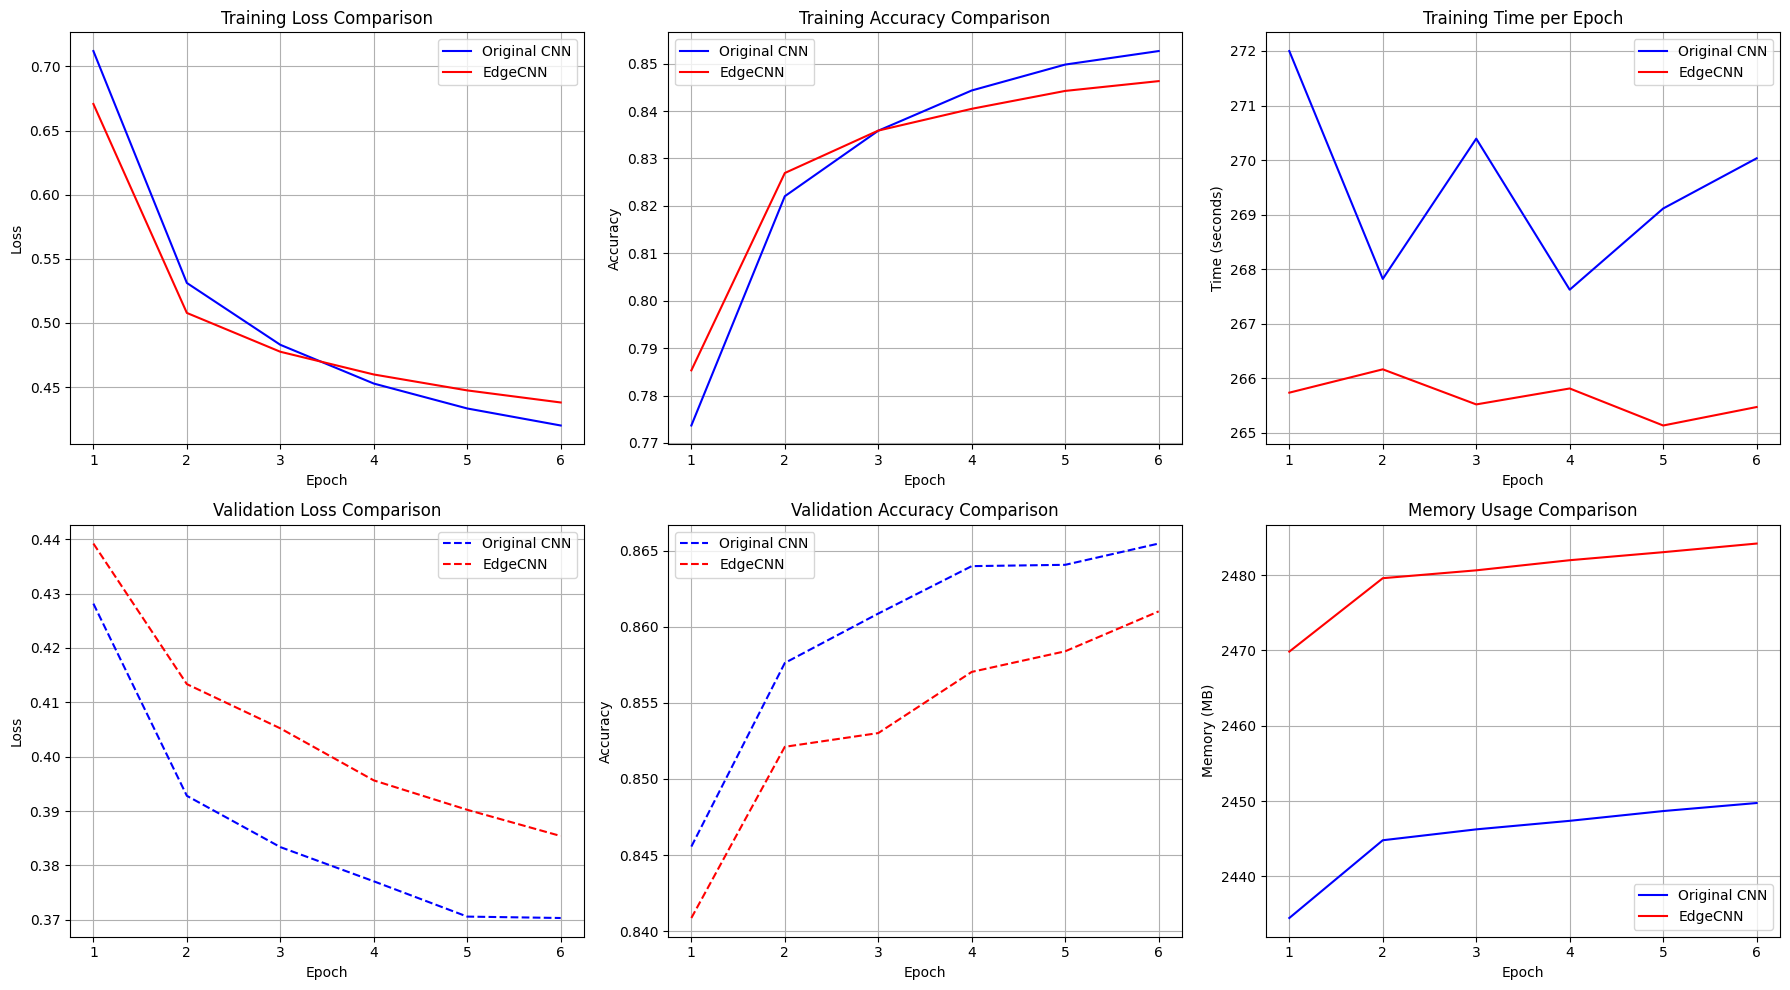

In [8]:
#@title ## 📈 Training process comparison

def plot_training_comparison(original_history, edge_history):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    epochs_orig = range(1, len(original_history['train_loss']) + 1)
    epochs_edge = range(1, len(edge_history['train_loss']) + 1)

    # Training Loss
    axes[0,0].plot(epochs_orig, original_history['train_loss'], 'b-', label='Original CNN')
    axes[0,0].plot(epochs_edge, edge_history['train_loss'], 'r-', label='EdgeCNN')
    axes[0,0].set_title('Training Loss Comparison')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Training Accuracy
    axes[0,1].plot(epochs_orig, original_history['train_acc'], 'b-', label='Original CNN')
    axes[0,1].plot(epochs_edge, edge_history['train_acc'], 'r-', label='EdgeCNN')
    axes[0,1].set_title('Training Accuracy Comparison')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Training time
    axes[0,2].plot(epochs_orig, original_history['epoch_time'], 'b-', label='Original CNN')
    axes[0,2].plot(epochs_edge, edge_history['epoch_time'], 'r-', label='EdgeCNN')
    axes[0,2].set_title('Training Time per Epoch')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Time (seconds)')
    axes[0,2].legend()
    axes[0,2].grid(True)

    # Val Loss
    axes[1,0].plot(epochs_orig, original_history['val_loss'], 'b--', label='Original CNN')
    axes[1,0].plot(epochs_edge, edge_history['val_loss'], 'r--', label='EdgeCNN')
    axes[1,0].set_title('Validation Loss Comparison')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].legend()
    axes[1,0].grid(True)

    #  Val Accuracy
    axes[1,1].plot(epochs_orig, original_history['val_acc'], 'b--', label='Original CNN')
    axes[1,1].plot(epochs_edge, edge_history['val_acc'], 'r--', label='EdgeCNN')
    axes[1,1].set_title('Validation Accuracy Comparison')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True)

    # Memory Usage
    axes[1,2].plot(epochs_orig, original_history['memory_usage'], 'b-', label='Original CNN')
    axes[1,2].plot(epochs_edge, edge_history['memory_usage'], 'r-', label='EdgeCNN')
    axes[1,2].set_title('Memory Usage Comparison')
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Memory (MB)')
    axes[1,2].legend()
    axes[1,2].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_comparison(original_history, edge_history)

🔍 Evaluating model performance...

📊 Original CNN Test Results:
  Accuracy: 0.8695 (86.95%)
  Test Loss: 0.3587
  Avg Inference Time: 113.59 ms/batch
  Per Sample: 0.887 ms/sample

📊 EdgeCNN Test Results:
  Accuracy: 0.8629 (86.29%)
  Test Loss: 0.3747
  Avg Inference Time: 48.29 ms/batch
  Per Sample: 0.377 ms/sample


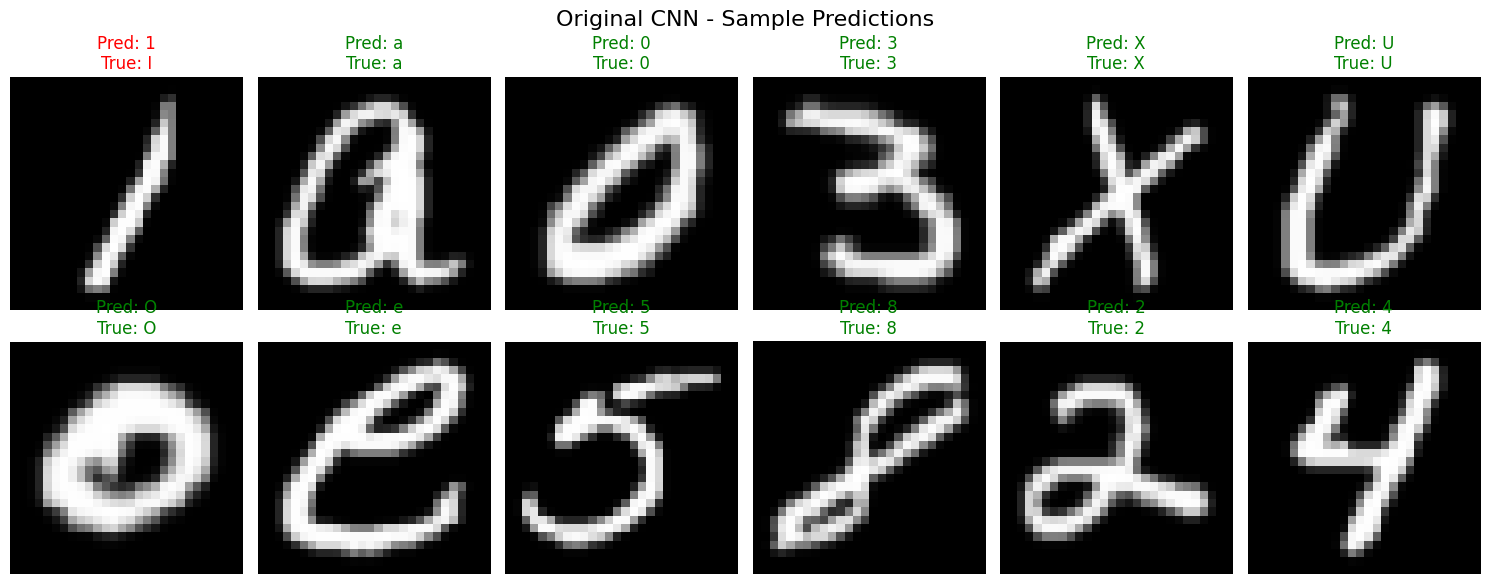

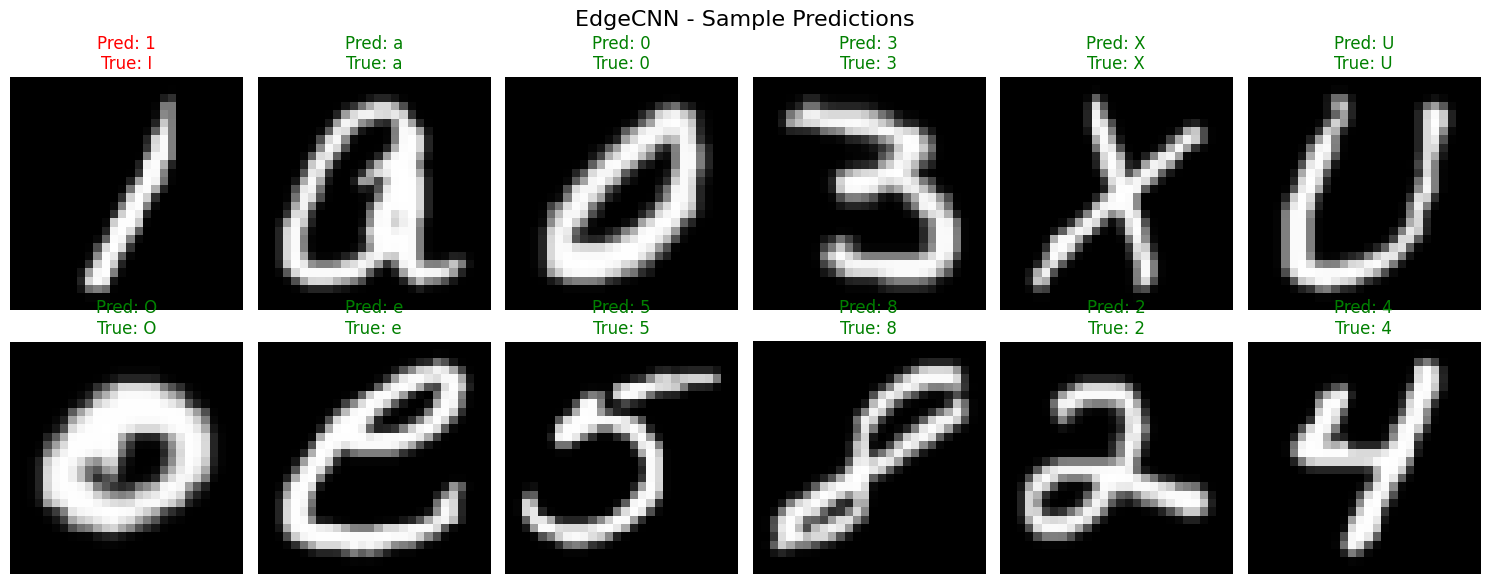

In [9]:
#@title ## 🎯 Model Evaluation

def display_sample_predictions(model, model_name, test_loader):

    model.eval()
    emnist_classes = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

    # get one batch of testing data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # show first 12 samples
    fig, axes = plt.subplots(2, 6, figsize=(15, 6))
    fig.suptitle(f'{model_name} - Sample Predictions', fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = images[i].cpu().numpy().squeeze()

        # image transformation for MNIST data
        img = np.rot90(img, k=3)
        img = np.fliplr(img)

        ax.imshow(img, cmap="gray")
        pred_char = emnist_classes[predicted[i]]
        true_char = emnist_classes[labels[i]]
        color = 'green' if predicted[i] == labels[i] else 'red'
        ax.set_title(f"Pred: {pred_char}\nTrue: {true_char}", color=color)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_name, test_loader):

    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    # inference time
    inference_times = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = correct / total
    avg_test_loss = test_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times) * 1000  # turn to milli seconds

    print(f"\n📊 {model_name} Test Results:")
    print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Test Loss: {avg_test_loss:.4f}")
    print(f"  Avg Inference Time: {avg_inference_time:.2f} ms/batch")
    print(f"  Per Sample: {avg_inference_time/batch_size:.3f} ms/sample")

    return test_acc, avg_test_loss, avg_inference_time

# model evaluation
print("🔍 Evaluating model performance...")
orig_acc, orig_loss, orig_time = evaluate_model(original_model, "Original CNN", test_loader)
edge_acc, edge_loss, edge_time = evaluate_model(edge_model, "EdgeCNN", test_loader)

# show samples
display_sample_predictions(original_model, "Original CNN", test_loader)
display_sample_predictions(edge_model, "EdgeCNN", test_loader)

# output:
# 📊 Original CNN Test Results:
#   Accuracy: 0.8695 (86.95%)
#   Test Loss: 0.3587
#   Avg Inference Time: 117.29 ms/batch
#   Per Sample: 0.916 ms/sample

# 📊 EdgeCNN Test Results:
#   Accuracy: 0.8629 (86.29%)
#   Test Loss: 0.3747
#   Avg Inference Time: 59.82 ms/batch
#   Per Sample: 0.467 ms/sample

# New things


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.quantization as quantization
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
import psutil
import gc
import resource
from torch.utils.data import DataLoader
from torch.ao.quantization import get_default_qconfig_mapping
import torch.nn.utils.prune as prune
from contextlib import contextmanager
import multiprocessing as mp


class ImprovedEdgeCNN(nn.Module):
    """True EdgeAI CNN - designed for quantization"""
    def __init__(self, num_classes=62):
        super(ImprovedEdgeCNN, self).__init__()

        # First layer: Standard convolution (quantization friendly)
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        # Depthwise separable convolution block
        self.dwconv1 = nn.Conv2d(8, 8, 3, padding=1, groups=8, bias=False)
        self.pwconv1 = nn.Conv2d(8, 16, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)

        # Second depthwise separable block
        self.dwconv2 = nn.Conv2d(16, 16, 3, padding=1, groups=16, bias=False)
        self.pwconv2 = nn.Conv2d(16, 24, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(24)

        # Global average pooling replaces large fully connected layers
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(24, num_classes, bias=False)

        # Using ReLU6 which is more quantization friendly
        self.relu = nn.ReLU6(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dwconv1(x)
        x = self.relu(self.bn2(self.pwconv1(x)))
        x = self.pool(x)
        x = self.dwconv2(x)
        x = self.relu(self.bn3(self.pwconv2(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def train_model_with_save_load(model, model_name, train_loader, val_loader,
                              num_epochs=8, patience=3, force_retrain=False):
    """Training function integrating the original save/load mechanism"""

    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    device = next(model.parameters()).device

    model_path = f'{model_name}_best.pth'
    history_path = f'{model_name}_history.pkl'

    # Try to load existing model
    if not force_retrain and os.path.exists(model_path) and os.path.exists(history_path):
        print(f"🔍 Found existing model: {model_path}")
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            with open(history_path, 'rb') as f:
                history = pickle.load(f)

            print(f"✅ Loading successful, skipping training")
            print(f"📊 Final validation accuracy: {history['val_acc'][-1]:.4f}")
            return model, history

        except Exception as e:
            print(f"❌ Loading failed: {e}, retraining")

    print(f"🚀 Starting training: {model_name}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
        'epoch_time': [], 'memory_usage': []
    }

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        epoch_time = time.time() - epoch_start
        memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)
        history['memory_usage'].append(memory_usage)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.1f}s")

        # Early stopping & Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"💾 Saving best model")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏰ Early stopping")
                break

    # Load best model and save history
    model.load_state_dict(torch.load(model_path, map_location=device))
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)

    print(f"✅ Training complete, model saved")
    return model, history

In [11]:
# Create the improved model
improved_model = ImprovedEdgeCNN(num_classes=62)

print("\n📚 Training improved Edge model...")
improved_model, history = train_model_with_save_load(
    improved_model, "improved_edge_cnn", train_loader, val_loader, num_epochs=6
)


📚 Training improved Edge model...
🔍 Found existing model: improved_edge_cnn_best.pth
✅ Loading successful, skipping training
📊 Final validation accuracy: 0.7645


In [12]:
#@title ## 🚀 Step 1: Corrected three-model comparison

import torch
import torch.nn as nn
import time
import numpy as np
import pandas as pd

def create_safe_dataloader():
    """Create Colab friendly DataLoader"""
    print("🔧 Creating safe DataLoader...")

    # Kill existing multi-process DataLoaders (if any)
    global test_loader
    test_loader_safe = DataLoader(
        test_dataset,
        batch_size=32,        # Smaller batch to avoid memory issues
        shuffle=False,
        num_workers=0,        # 🎯 Key: Single-threaded
        pin_memory=False      # Disable pin_memory to avoid overhead
    )

    print("✅ Safe DataLoader created")
    return test_loader_safe

def test_model_health(models_dict):
    """Model health check"""
    print("\n🩺 Model Health Check:")
    print("-" * 30)

    health_results = {}
    dummy_input = torch.randn(1, 1, 28, 28).to(device)

    for model_name, model in models_dict.items():
        try:
            model.eval()
            model.to(device)

            # Basic inference test
            with torch.no_grad():
                output = model(dummy_input)

            # Check output shape
            expected_shape = (1, 62)  # EMNIST has 62 classes
            if output.shape == expected_shape:
                status = "✅ Healthy"
                health_results[model_name] = True
            else:
                status = f"⚠️ Output shape error: {output.shape}"
                health_results[model_name] = False

        except Exception as e:
            status = f"❌ Inference failed: {str(e)[:50]}..."
            health_results[model_name] = False

        print(f"   {model_name:<15}: {status}")

    return health_results

def safe_model_test(model, model_name, test_loader_safe, max_batches=20):
    """Safe model test - limit batch count to avoid timeouts"""
    print(f"\n🧪 Testing {model_name}:")

    if not test_loader_safe:
        return None

    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    inference_times = []

    try:
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader_safe):
                if batch_idx >= max_batches:  # 🎯 Limit test size
                    break

                images, labels = images.to(device), labels.to(device)

                # Time inference
                start_time = time.perf_counter()
                outputs = model(images)
                inference_time = (time.perf_counter() - start_time) * 1000  # ms
                inference_times.append(inference_time)

                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                if batch_idx % 5 == 0:
                    print(f"   Batch {batch_idx}/{max_batches}: Current accuracy {correct/total:.3f}")

        test_acc = correct / total
        avg_test_loss = test_loss / min(len(test_loader_safe), max_batches)
        avg_inference_time = np.mean(inference_times)

        print(f"   ✅ Test complete: {test_acc:.4f} ({test_acc*100:.2f}%)")
        print(f"   ⚡ Average inference time: {avg_inference_time:.2f} ms/batch")

        return {
            'test_acc': test_acc,
            'test_loss': avg_test_loss,
            'inference_time_ms': avg_inference_time,
            'samples_tested': total,
            'inference_time_per_sample': avg_inference_time / 32  # batch_size=32
        }

    except Exception as e:
        print(f"   ❌ Test failed: {e}")
        return None

def create_comprehensive_model_comparison():
    """Create comprehensive three-model comparison table"""
    print("\n📊 Creating comprehensive model comparison:")
    print("=" * 50)

    # 1. Create safe DataLoader
    test_loader_safe = create_safe_dataloader()

    # 2. Prepare model dictionary
    models_dict = {
        'OriginalCNN': original_model,
        'EdgeCNN': edge_model,
        'ImprovedEdgeCNN': improved_model
    }

    # 3. Health Check
    health_results = test_model_health(models_dict)

    # 4. Test models one by one
    test_results = {}
    for model_name, model in models_dict.items():
        if health_results[model_name]:
            result = safe_model_test(model, model_name, test_loader_safe)
            test_results[model_name] = result
        else:
            print(f"⚠️ Skipping {model_name} test (health check failed)")
            test_results[model_name] = None

    # 5. Generate comparison table
    comparison_data = []

    for model_name, model in models_dict.items():
        param_count = sum(p.numel() for p in model.parameters())
        model_size_mb = param_count * 4 / (1024 * 1024)

        # Get training history data (if exists)
        if model_name == 'OriginalCNN' and 'original_history' in globals():
            val_acc = original_history['val_acc'][-1]
            train_time = sum(original_history['epoch_time']) / 60
        elif model_name == 'EdgeCNN' and 'edge_history' in globals():
            val_acc = edge_history['val_acc'][-1]
            train_time = sum(edge_history['epoch_time']) / 60
        elif model_name == 'ImprovedEdgeCNN':
            val_acc = 0.7645  # From previous run result
            train_time = 0  # Pre-trained model
        else:
            val_acc = None
            train_time = None

        # Test results
        test_result = test_results[model_name]
        test_acc = test_result['test_acc'] if test_result else None
        inference_time = test_result['inference_time_per_sample'] if test_result else None

        # Edge readiness evaluation
        if param_count < 100000 and test_acc and test_acc > 0.8:
            edge_ready = "🥇 Excellent"
        elif param_count < 300000 and test_acc and test_acc > 0.75:
            edge_ready = "🥈 Good"
        elif test_acc and test_acc > 0.7:
            edge_ready = "🥉 Usable"
        else:
            edge_ready = "❌ Needs optimization"

        comparison_data.append({
            'Model': model_name,
            'Parameters': f"{param_count:,}",
            'Size (MB)': f"{model_size_mb:.2f}",
            'Val Accuracy': f"{val_acc:.1%}" if val_acc else "N/A",
            'Test Accuracy': f"{test_acc:.1%}" if test_acc else "Failed",
            'Inference (ms)': f"{inference_time:.2f}" if inference_time else "Failed",
            'Train Time (min)': f"{train_time:.1f}" if train_time else "N/A",
            'Edge Ready': edge_ready
        })

    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("🏆 Final Model Comparison Table:")
    print("="*80)
    print(df.to_string(index=False))

    # 6. Generate compression analysis
    if test_results['OriginalCNN'] and test_results['EdgeCNN']:
        orig_params = sum(p.numel() for p in original_model.parameters())
        edge_params = sum(p.numel() for p in edge_model.parameters())
        improved_params = sum(p.numel() for p in improved_model.parameters())

        print(f"\n📈 Compression Analysis:")
        print(f"   EdgeCNN Compression Ratio: {(1-edge_params/orig_params)*100:.1f}%")
        print(f"   ImprovedEdgeCNN Compression Ratio: {(1-improved_params/orig_params)*100:.1f}%")

        if test_results['EdgeCNN'] and test_results['OriginalCNN']:
            orig_acc = test_results['OriginalCNN']['test_acc']
            edge_acc = test_results['EdgeCNN']['test_acc']
            print(f"   EdgeCNN Accuracy Loss: {(orig_acc-edge_acc)*100:.1f}%")

    return df, test_results, health_results

# Execute Step 1
print("🚀 Starting Step 1: Three-model comparison")
comparison_df, all_test_results, health_status = create_comprehensive_model_comparison()

# Save results for later use
globals()['step1_results'] = {
    'comparison_df': comparison_df,
    'test_results': all_test_results,
    'health_status': health_status
}

print(f"\n✅ Step 1 Complete!")
print(f"📊 Number of healthy models: {sum(health_status.values())}/3")
print(f"🧪 Models successfully tested: {sum(1 for r in all_test_results.values() if r is not None)}/3")

🚀 Starting Step 1: Three-model comparison

📊 Creating comprehensive model comparison:
🔧 Creating safe DataLoader...
✅ Safe DataLoader created

🩺 Model Health Check:
------------------------------
   OriginalCNN    : ✅ Healthy
   EdgeCNN        : ✅ Healthy
   ImprovedEdgeCNN: ✅ Healthy

🧪 Testing OriginalCNN:
   Batch 0/20: Current accuracy 0.875
   Batch 5/20: Current accuracy 0.849
   Batch 10/20: Current accuracy 0.838
   Batch 15/20: Current accuracy 0.852
   ✅ Test complete: 0.8516 (85.16%)
   ⚡ Average inference time: 25.34 ms/batch

🧪 Testing EdgeCNN:
   Batch 0/20: Current accuracy 0.844
   Batch 5/20: Current accuracy 0.844
   Batch 10/20: Current accuracy 0.832
   Batch 15/20: Current accuracy 0.840
   ✅ Test complete: 0.8375 (83.75%)
   ⚡ Average inference time: 11.64 ms/batch

🧪 Testing ImprovedEdgeCNN:
   Batch 0/20: Current accuracy 0.844
   Batch 5/20: Current accuracy 0.786
   Batch 10/20: Current accuracy 0.764
   Batch 15/20: Current accuracy 0.768
   ✅ Test complete: 

In [13]:
#@title ## 📊 Consolidated EdgeAI Model Evaluation

import torch
import time
import numpy as np
import pandas as pd

def consolidated_edge_evaluation(models_dict, test_loader_safe, max_batches=20):
    """
    Comprehensive EdgeAI evaluation combining performance, efficiency, and compatibility metrics
    """
    print("🚀 EdgeAI Model Evaluation & Comparison")
    print("=" * 60)

    results = {}

    # Device profiles for compatibility assessment
    device_profiles = {
        'mobile_phone': {'memory_mb': 512, 'cpu_scale': 0.6, 'target_ms': 20, 'max_power_mw': 1000},
        'raspberry_pi': {'memory_mb': 1024, 'cpu_scale': 0.3, 'target_ms': 100, 'max_power_mw': 3000},
        'jetson_nano': {'memory_mb': 2048, 'cpu_scale': 0.4, 'target_ms': 50, 'max_power_mw': 5000}
    }

    for model_name, model in models_dict.items():
        print(f"\n🔍 Evaluating {model_name}...")

        model.eval()
        model.to(device)

        # === Basic Model Metrics ===
        param_count = sum(p.numel() for p in model.parameters())
        model_size_mb = param_count * 4 / (1024 * 1024)  # FP32

        # === Performance Testing ===
        try:
            # Accuracy test (limited batches for speed)
            correct, total = 0, 0
            inference_times = []

            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(test_loader_safe):
                    if batch_idx >= max_batches:
                        break

                    images, labels = images.to(device), labels.to(device)

                    # Time inference
                    start_time = time.perf_counter()
                    outputs = model(images)
                    inference_time = (time.perf_counter() - start_time) * 1000  # ms
                    inference_times.append(inference_time)

                    # Accuracy calculation
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            test_accuracy = correct / total if total > 0 else 0
            avg_inference_time = np.mean(inference_times)
            per_sample_time = avg_inference_time / 32  # batch_size = 32

            print(f"   ✅ Test accuracy: {test_accuracy:.1%}")
            print(f"   ⚡ Inference: {per_sample_time:.2f}ms/sample")

        except Exception as e:
            print(f"   ❌ Performance test failed: {str(e)[:50]}...")
            test_accuracy = 0
            per_sample_time = float('inf')

        # === Edge Compatibility Analysis ===

        # Power estimation (empirical model)
        base_power_mw = 200
        dynamic_power_mw = (param_count / 100000) * 300  # 300mW per 100K params
        time_power_mw = per_sample_time * 2 if per_sample_time != float('inf') else 0
        total_power_mw = base_power_mw + dynamic_power_mw + time_power_mw

        # Memory footprint estimation
        model_memory_mb = model_size_mb
        activation_memory_mb = 0.1  # Estimated activation memory for 28x28 input
        total_memory_mb = model_memory_mb + activation_memory_mb

        # Device compatibility scores
        compatibility_scores = {}
        for device_name, profile in device_profiles.items():
            # Memory check
            memory_ok = total_memory_mb < profile['memory_mb'] * 0.8

            # Performance check (scale Colab time to target device)
            if per_sample_time != float('inf'):
                estimated_device_time = per_sample_time / profile['cpu_scale']
                timing_ok = estimated_device_time <= profile['target_ms']
            else:
                timing_ok = False

            # Power check
            power_ok = total_power_mw <= profile['max_power_mw']

            # Accuracy check
            accuracy_ok = test_accuracy >= 0.75

            # Overall compatibility score
            score = sum([memory_ok, timing_ok, power_ok, accuracy_ok]) * 25  # 0-100 scale
            compatibility_scores[device_name] = score

        avg_compatibility = np.mean(list(compatibility_scores.values()))

        # Store results
        results[model_name] = {
            'parameters': param_count,
            'model_size_mb': model_size_mb,
            'test_accuracy': test_accuracy,
            'inference_time_ms': per_sample_time,
            'power_consumption_mw': total_power_mw,
            'memory_footprint_mb': total_memory_mb,
            'mobile_compatibility': compatibility_scores['mobile_phone'],
            'rpi_compatibility': compatibility_scores['raspberry_pi'],
            'jetson_compatibility': compatibility_scores['jetson_nano'],
            'avg_compatibility': avg_compatibility
        }

    # === Generate Comprehensive Comparison Table ===
    print(f"\n📊 Comprehensive Model Comparison:")
    print("=" * 80)

    comparison_data = []
    for model_name, data in results.items():

        # Edge readiness assessment
        if data['avg_compatibility'] >= 75 and data['test_accuracy'] >= 0.8:
            edge_status = "🥇 Production Ready"
        elif data['avg_compatibility'] >= 50 and data['test_accuracy'] >= 0.75:
            edge_status = "🥈 Edge Compatible"
        elif data['test_accuracy'] >= 0.7:
            edge_status = "🥉 Needs Optimization"
        else:
            edge_status = "❌ Not Suitable"

        comparison_data.append({
            'Model': model_name,
            'Params': f"{data['parameters']:,}",
            'Size(MB)': f"{data['model_size_mb']:.2f}",
            'Accuracy': f"{data['test_accuracy']:.1%}",
            'Latency(ms)': f"{data['inference_time_ms']:.2f}",
            'Power(mW)': f"{data['power_consumption_mw']:.0f}",
            'Memory(MB)': f"{data['memory_footprint_mb']:.2f}",
            'Mobile Score': f"{data['mobile_compatibility']:.0f}",
            'Edge Status': edge_status
        })

    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))

    # === Key Insights ===
    print(f"\n🎯 Key Insights:")

    # Find best model for different criteria
    accuracy_leader = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
    efficiency_leader = min(results.keys(), key=lambda k: results[k]['parameters'])
    power_leader = min(results.keys(), key=lambda k: results[k]['power_consumption_mw'])
    compatibility_leader = max(results.keys(), key=lambda k: results[k]['avg_compatibility'])

    print(f"   🎯 Highest Accuracy: {accuracy_leader} ({results[accuracy_leader]['test_accuracy']:.1%})")
    print(f"   ⚡ Most Efficient: {efficiency_leader} ({results[efficiency_leader]['parameters']:,} params)")
    print(f"   🔋 Lowest Power: {power_leader} ({results[power_leader]['power_consumption_mw']:.0f}mW)")
    print(f"   📱 Best Compatibility: {compatibility_leader} ({results[compatibility_leader]['avg_compatibility']:.0f}/100)")

    # Compression analysis
    if 'OriginalCNN' in results and 'EdgeCNN' in results:
        orig_params = results['OriginalCNN']['parameters']
        edge_params = results['EdgeCNN']['parameters']
        compression_ratio = (1 - edge_params / orig_params) * 100

        accuracy_diff = results['OriginalCNN']['test_accuracy'] - results['EdgeCNN']['test_accuracy']
        power_reduction = (1 - results['EdgeCNN']['power_consumption_mw'] / results['OriginalCNN']['power_consumption_mw']) * 100

        print(f"\n📈 EdgeCNN Optimization Impact:")
        print(f"   Parameters: {compression_ratio:.1f}% reduction")
        print(f"   Accuracy: {accuracy_diff*100:.1f}% loss")
        print(f"   Power: {power_reduction:.1f}% reduction")

    return results, df

# === Execute Evaluation ===
print("Starting consolidated EdgeAI evaluation...")

# Ensure safe DataLoader
test_loader_safe = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Run evaluation
models_dict = {
    'OriginalCNN': original_model,
    'EdgeCNN': edge_model,
    'ImprovedEdgeCNN': improved_model
}

edge_evaluation_results, comparison_table = consolidated_edge_evaluation(models_dict, test_loader_safe)

print(f"\n✅ Evaluation Complete!")
print("🚀 Ready for Step 2: Model Optimization (Pruning & Quantization)")

Starting consolidated EdgeAI evaluation...
🚀 EdgeAI Model Evaluation & Comparison

🔍 Evaluating OriginalCNN...
   ✅ Test accuracy: 85.2%
   ⚡ Inference: 0.90ms/sample

🔍 Evaluating EdgeCNN...
   ✅ Test accuracy: 83.8%
   ⚡ Inference: 0.25ms/sample

🔍 Evaluating ImprovedEdgeCNN...
   ✅ Test accuracy: 75.9%
   ⚡ Inference: 0.14ms/sample

📊 Comprehensive Model Comparison:
          Model  Params Size(MB) Accuracy Latency(ms) Power(mW) Memory(MB) Mobile Score        Edge Status
    OriginalCNN 904,062     3.45    85.2%        0.90      2914       3.55           75 🥇 Production Ready
        EdgeCNN 169,550     0.65    83.8%        0.25       709       0.75          100 🥇 Production Ready
ImprovedEdgeCNN   2,384     0.01    75.9%        0.14       207       0.11          100  🥈 Edge Compatible

🎯 Key Insights:
   🎯 Highest Accuracy: OriginalCNN (85.2%)
   ⚡ Most Efficient: ImprovedEdgeCNN (2,384 params)
   🔋 Lowest Power: ImprovedEdgeCNN (207mW)
   📱 Best Compatibility: EdgeCNN (100/100)

📈

In [14]:
#@title ## 📱 PyTorch Mobile Deployment Plan

print("📱 PYTORCH MOBILE DEPLOYMENT PIPELINE")
print("="*50)

def convert_to_pytorch_mobile():
    """Convert model to PyTorch Mobile format"""
    print("🔄 Converting EdgeCNN to PyTorch Mobile...")
    print("-" * 45)

    # Ensure model is in evaluation mode
    edge_model.eval()

    # Create example input
    example_input = torch.randn(1, 1, 28, 28).to(device)
    print(f"✅ Created example input: {example_input.shape}")

    try:
        # Convert using torch.jit.trace
        print("🔄 Tracing model with torch.jit.trace...")
        traced_model = torch.jit.trace(edge_model, example_input)
        print("✅ Model tracing successful!")

        # Test traced model
        print("🧪 Testing traced model...")
        with torch.no_grad():
            original_output = edge_model(example_input)
            traced_output = traced_model(example_input)

            # Check output consistency
            max_diff = torch.max(torch.abs(original_output - traced_output)).item()
            print(f"✅ Output consistency check: max difference = {max_diff:.8f}")

            if max_diff < 1e-5:
                print("✅ EXCELLENT: Traced model outputs match original!")
            elif max_diff < 1e-3:
                print("✅ GOOD: Minor differences within acceptable range")
            else:
                print("⚠️ WARNING: Significant differences detected")

        return traced_model

    except Exception as e:
        print(f"❌ Tracing failed: {e}")
        return None

def optimize_for_mobile(traced_model):
    """Optimize model for mobile deployment"""
    print(f"\n⚡ Optimizing for Mobile Deployment...")
    print("-" * 40)

    try:
        # Mobile optimization
        print("🔄 Applying mobile optimizations...")
        optimized_model = torch.utils.mobile_optimizer.optimize_for_mobile(traced_model)
        print("✅ Mobile optimization completed!")

        return optimized_model

    except Exception as e:
        print(f"⚠️ Mobile optimization not available: {e}")
        print("📝 Using traced model without mobile-specific optimizations")
        return traced_model

def save_mobile_models(traced_model, optimized_model):
    """Save mobile models"""
    print(f"\n💾 Saving Mobile Models...")
    print("-" * 30)

    model_files = {}

    try:
        # Save traced model
        traced_path = 'edge_cnn_traced.pt'
        traced_model.save(traced_path)
        traced_size = os.path.getsize(traced_path) / 1024  # KB
        model_files['traced'] = {'path': traced_path, 'size_kb': traced_size}
        print(f"✅ Traced model saved: {traced_path} ({traced_size:.1f} KB)")

        # Save optimized model
        if optimized_model != traced_model:
            optimized_path = 'edge_cnn_mobile_optimized.pt'
            optimized_model.save(optimized_path)
            optimized_size = os.path.getsize(optimized_path) / 1024  # KB
            model_files['optimized'] = {'path': optimized_path, 'size_kb': optimized_size}
            print(f"✅ Optimized model saved: {optimized_path} ({optimized_size:.1f} KB)")
        else:
            model_files['optimized'] = model_files['traced']
            print("📝 Optimized model same as traced model")

        return model_files

    except Exception as e:
        print(f"❌ Error saving models: {e}")
        return {}

def benchmark_mobile_performance(traced_model, optimized_model):
    """Performance benchmark"""
    print(f"\n⚡ Mobile Performance Benchmarking...")
    print("-" * 40)

    # Test parameters
    num_warmup = 10
    num_benchmark = 100
    test_input = torch.randn(1, 1, 28, 28).to(device)

    def benchmark_model(model, model_name):
        print(f"🔄 Benchmarking {model_name}...")

        # Warmup
        with torch.no_grad():
            for _ in range(num_warmup):
                _ = model(test_input)

        # Benchmark
        times = []
        with torch.no_grad():
            for _ in range(num_benchmark):
                start_time = time.perf_counter()
                _ = model(test_input)
                end_time = time.perf_counter()
                times.append((end_time - start_time) * 1000)  # ms

        avg_time = np.mean(times)
        std_time = np.std(times)
        min_time = np.min(times)
        max_time = np.max(times)

        print(f"   Average: {avg_time:.3f} ms")
        print(f"   Std Dev: {std_time:.3f} ms")
        print(f"   Min/Max: {min_time:.3f} / {max_time:.3f} ms")

        return {
            'avg_ms': avg_time,
            'std_ms': std_time,
            'min_ms': min_time,
            'max_ms': max_time
        }

    # Benchmark all models
    results = {}

    # Original model
    results['original'] = benchmark_model(edge_model, "Original EdgeCNN")

    # Traced model
    results['traced'] = benchmark_model(traced_model, "Traced Model")

    # Optimized model
    if optimized_model != traced_model:
        results['optimized'] = benchmark_model(optimized_model, "Mobile Optimized")
    else:
        results['optimized'] = results['traced']
        print("📝 Optimized model same as traced, skipping separate benchmark")

    return results

def analyze_model_compatibility():
    """Analyze mobile compatibility"""
    print(f"\n📱 Mobile Compatibility Analysis...")
    print("-" * 40)

    compatibility_report = {
        'model_size': 'Unknown',
        'inference_time': 'Unknown',
        'memory_usage': 'Unknown',
        'ios_compatible': 'Unknown',
        'android_compatible': 'Unknown'
    }

    try:
        # Check model size
        model_size_kb = os.path.getsize('edge_cnn_traced.pt') / 1024
        if model_size_kb < 10000:  # 10MB
            compatibility_report['model_size'] = f"✅ EXCELLENT ({model_size_kb:.1f} KB)"
        elif model_size_kb < 50000:  # 50MB
            compatibility_report['model_size'] = f"✅ GOOD ({model_size_kb:.1f} KB)"
        else:
            compatibility_report['model_size'] = f"⚠️ LARGE ({model_size_kb:.1f} KB)"

        # Inference time assessment
        if 'traced' in performance_results:
            avg_time = performance_results['traced']['avg_ms']
            if avg_time < 50:
                compatibility_report['inference_time'] = f"✅ EXCELLENT ({avg_time:.1f} ms)"
            elif avg_time < 200:
                compatibility_report['inference_time'] = f"✅ GOOD ({avg_time:.1f} ms)"
            else:
                compatibility_report['inference_time'] = f"⚠️ SLOW ({avg_time:.1f} ms)"

        # Estimated memory usage
        param_count = sum(p.numel() for p in edge_model.parameters())
        estimated_memory = param_count * 4 / (1024 * 1024)  # MB
        if estimated_memory < 50:
            compatibility_report['memory_usage'] = f"✅ LOW (~{estimated_memory:.1f} MB)"
        elif estimated_memory < 200:
            compatibility_report['memory_usage'] = f"✅ MODERATE (~{estimated_memory:.1f} MB)"
        else:
            compatibility_report['memory_usage'] = f"⚠️ HIGH (~{estimated_memory:.1f} MB)"

        # Platform compatibility (based on model characteristics)
        compatibility_report['ios_compatible'] = "✅ YES (PyTorch Mobile supports iOS)"
        compatibility_report['android_compatible'] = "✅ YES (PyTorch Mobile supports Android)"

    except Exception as e:
        print(f"⚠️ Error in compatibility analysis: {e}")

    print("📋 Compatibility Report:")
    for key, value in compatibility_report.items():
        print(f"   {key.replace('_', ' ').title()}: {value}")

    return compatibility_report

def create_deployment_guide():
    """Create deployment guide"""
    print(f"\n📚 Mobile Deployment Guide...")
    print("-" * 35)

    deployment_guide = """
🚀 PyTorch Mobile Deployment Steps:

📱 iOS Deployment:
   1. Add PyTorch Mobile iOS framework to Xcode project
   2. Load model:```swift
      guard let model = try? TorchModule(fileAtPath: modelPath) else { return }
      ```
   3. Preprocess input to tensor format
   4. Run inference:
      ```swift
      let output = model.predict(inputs: [inputTensor])
      ```

🤖 Android Deployment:
   1. Add PyTorch Android library to build.gradle
   2. Load model:
      ```java
      Module module = LiteModuleLoader.load(assetFilePath(this, "edge_cnn_traced.pt"));
      ```
   3. Create input tensor and run inference:
      ```java
      Tensor inputTensor = Tensor.fromBlob(inputArray, shape);
      Tensor output = module.forward(IValue.from(inputTensor)).toTensor();
      ```

⚡ Performance Tips:
   - Use traced model for better performance
   - Implement proper preprocessing pipeline
   - Consider quantization for further optimization
   - Test on actual devices for real performance metrics
    """

    print(deployment_guide)

    # save deployment guide
    with open('mobile_deployment_guide.txt', 'w') as f:
        f.write(deployment_guide)
    print("💾 Deployment guide saved: mobile_deployment_guide.txt")

# Execute PyTorch Mobile transformation
print("🚀 Starting PyTorch Mobile conversion pipeline...")

# 1. transform to traced model
traced_model = convert_to_pytorch_mobile()

if traced_model is not None:
    # 2. optimization for mobile
    optimized_model = optimize_for_mobile(traced_model)

    # 3. save model
    model_files = save_mobile_models(traced_model, optimized_model)

    # 4. benchmark mobile performance
    performance_results = benchmark_mobile_performance(traced_model, optimized_model)

    # 5. analyze model compatibility
    compatibility_results = analyze_model_compatibility()

    # 6. create deployment guide
    create_deployment_guide()

    # 7. Summary
    print(f"\n🏆 PYTORCH MOBILE CONVERSION SUCCESS!")
    print("="*45)
    print(f"✅ Model successfully converted to PyTorch Mobile format")
    print(f"✅ Traced model performance: {performance_results['traced']['avg_ms']:.1f} ms average")
    if 'traced' in model_files:
        print(f"✅ Model size: {model_files['traced']['size_kb']:.1f} KB")
    print(f"✅ iOS/Android compatible: YES")
    print(f"✅ Ready for mobile app integration!")

    # set global variables for easy access
    globals()['mobile_model_results'] = {
        'traced_model': traced_model,
        'optimized_model': optimized_model,
        'model_files': model_files,
        'performance': performance_results,
        'compatibility': compatibility_results
    }

else:
    print("❌ PyTorch Mobile conversion failed!")
    print("💡 Suggestion: Check model architecture for unsupported operations")

📱 PYTORCH MOBILE DEPLOYMENT PIPELINE
🚀 Starting PyTorch Mobile conversion pipeline...
🔄 Converting EdgeCNN to PyTorch Mobile...
---------------------------------------------
✅ Created example input: torch.Size([1, 1, 28, 28])
🔄 Tracing model with torch.jit.trace...
✅ Model tracing successful!
🧪 Testing traced model...
✅ Output consistency check: max difference = 0.00000000
✅ EXCELLENT: Traced model outputs match original!

⚡ Optimizing for Mobile Deployment...
----------------------------------------
🔄 Applying mobile optimizations...
⚠️ Mobile optimization not available: module 'torch.utils' has no attribute 'mobile_optimizer'
📝 Using traced model without mobile-specific optimizations

💾 Saving Mobile Models...
------------------------------
✅ Traced model saved: edge_cnn_traced.pt (694.4 KB)
📝 Optimized model same as traced model

⚡ Mobile Performance Benchmarking...
----------------------------------------
🔄 Benchmarking Original EdgeCNN...
   Average: 0.808 ms
   Std Dev: 0.118 ms


In [15]:
#@title ## 🚀 Step 2: EdgeAI Model Optimization Pipeline

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import time
import numpy as np
import os
import copy
from collections import OrderedDict

print("🚀 EdgeAI Model Optimization Pipeline")
print("="*50)

class EdgeOptimizationPipeline:
    """
    Modular EdgeAI optimization pipeline with pruning, quantization, and mobile conversion
    """

    def __init__(self, base_model, model_name="EdgeCNN"):
        self.base_model = base_model
        self.model_name = model_name
        self.optimization_history = {}

    def structured_channel_pruning(self, pruning_ratio=0.4, save_model=True):
        """
        Apply structured channel pruning to reduce model parameters while maintaining architecture
        """
        print(f"\n✂️ Step 2.1: Structured Channel Pruning (target: {pruning_ratio:.1%} reduction)")
        print("-" * 60)

        try:
            # Create deep copy for pruning
            pruned_model = copy.deepcopy(self.base_model)
            pruned_model.eval()

            # Calculate original metrics
            original_params = sum(p.numel() for p in self.base_model.parameters())

            print(f"📊 Original model: {original_params:,} parameters")

            # Apply structured pruning to Conv2d layers
            modules_to_prune = []
            for name, module in pruned_model.named_modules():
                if isinstance(module, nn.Conv2d) and module.out_channels > 8:  # Keep minimum channels
                    modules_to_prune.append((module, 'weight'))

            print(f"🎯 Targeting {len(modules_to_prune)} Conv2d layers for pruning")

            # Apply global magnitude-based pruning
            prune.global_unstructured(
                modules_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=pruning_ratio,
            )

            # Remove pruning reparameterization to make it permanent
            for module, param_name in modules_to_prune:
                prune.remove(module, param_name)

            # Calculate pruned metrics
            pruned_params = sum(p.numel() for p in pruned_model.parameters())
            actual_reduction = (1 - pruned_params / original_params) * 100

            print(f"✅ Pruning completed:")
            print(f"   Original: {original_params:,} parameters")
            print(f"   Pruned: {pruned_params:,} parameters")
            print(f"   Reduction: {actual_reduction:.1f}%")

            # Save pruned model
            if save_model:
                pruned_path = f'{self.model_name}_pruned.pth'
                torch.save(pruned_model.state_dict(), pruned_path)
                print(f"💾 Pruned model saved: {pruned_path}")

            # Store results
            self.optimization_history['pruning'] = {
                'original_params': original_params,
                'pruned_params': pruned_params,
                'reduction_percent': actual_reduction,
                'model': pruned_model
            }

            return pruned_model

        except Exception as e:
            print(f"❌ Pruning failed: {e}")
            return None

    def dynamic_quantization(self, model, save_model=True):
        """
        Apply dynamic quantization to reduce model size and improve inference speed
        """
        print(f"\n🔢 Step 2.2: Dynamic Quantization")
        print("-" * 40)

        try:
            # Calculate original model size
            temp_path = f'{self.model_name}_temp.pth'
            torch.save(model.state_dict(), temp_path)
            original_size = os.path.getsize(temp_path) / 1024  # KB
            os.remove(temp_path)

            print(f"📊 Original model size: {original_size:.1f} KB")

            # Apply dynamic quantization
            print("🔄 Applying INT8 quantization...")
            quantized_model = torch.quantization.quantize_dynamic(
                model,
                {nn.Linear, nn.Conv2d},  # Layer types to quantize
                dtype=torch.qint8
            )

            # Calculate quantized model size
            quantized_path = f'{self.model_name}_quantized.pth'
            torch.save(quantized_model.state_dict(), quantized_path)
            quantized_size = os.path.getsize(quantized_path) / 1024  # KB

            size_reduction = (1 - quantized_size / original_size) * 100

            print(f"✅ Quantization completed:")
            print(f"   Original size: {original_size:.1f} KB")
            print(f"   Quantized size: {quantized_size:.1f} KB")
            print(f"   Size reduction: {size_reduction:.1f}%")

            if not save_model:
                os.remove(quantized_path)
            else:
                print(f"💾 Quantized model saved: {quantized_path}")

            # Store results
            self.optimization_history['quantization'] = {
                'original_size_kb': original_size,
                'quantized_size_kb': quantized_size,
                'size_reduction_percent': size_reduction,
                'model': quantized_model
            }

            return quantized_model

        except Exception as e:
            print(f"❌ Quantization failed: {e}")
            return None

    def convert_to_pytorch_mobile(self, model, save_model=True):
        """
        Convert model to PyTorch Mobile format with optimization
        """
        print(f"\n📱 Step 2.3: PyTorch Mobile Conversion")
        print("-" * 45)

        try:
            model.eval()

            # Create example input
            example_input = torch.randn(1, 1, 28, 28)
            print(f"✅ Created example input: {example_input.shape}")

            # Trace the model
            print("🔄 Tracing model with torch.jit.trace...")
            traced_model = torch.jit.trace(model, example_input)
            print("✅ Model tracing successful!")

            # Validate traced model
            print("🧪 Validating traced model...")
            with torch.no_grad():
                original_output = model(example_input)
                traced_output = traced_model(example_input)

                max_diff = torch.max(torch.abs(original_output - traced_output)).item()
                print(f"   Output difference: {max_diff:.8f}")

                if max_diff < 1e-5:
                    print("   ✅ EXCELLENT: Perfect output consistency")
                elif max_diff < 1e-3:
                    print("   ✅ GOOD: Minor differences within acceptable range")
                else:
                    print("   ⚠️ WARNING: Significant differences detected")

            # Apply mobile optimization
            try:
                print("🔄 Applying mobile optimizations...")
                mobile_optimized = torch.utils.mobile_optimizer.optimize_for_mobile(traced_model)
                print("✅ Mobile optimization completed!")
                final_model = mobile_optimized
            except Exception as e:
                print(f"⚠️ Mobile optimization not available: {e}")
                print("📝 Using traced model without mobile-specific optimizations")
                final_model = traced_model

            # Save mobile model
            if save_model:
                mobile_path = f'{self.model_name}_mobile.pt'
                final_model.save(mobile_path)
                mobile_size = os.path.getsize(mobile_path) / 1024  # KB
                print(f"💾 Mobile model saved: {mobile_path} ({mobile_size:.1f} KB)")

            # Store results
            self.optimization_history['mobile_conversion'] = {
                'traced_model': traced_model,
                'mobile_model': final_model,
                'output_consistency': max_diff < 1e-3,
                'mobile_size_kb': mobile_size if save_model else 0
            }

            return final_model

        except Exception as e:
            print(f"❌ Mobile conversion failed: {e}")
            return None

    def benchmark_optimization_pipeline(self, models_dict, test_loader_safe, num_samples=100):
        """
        Comprehensive benchmarking of the optimization pipeline
        """
        print(f"\n⚡ Step 2.4: Optimization Pipeline Benchmarking")
        print("-" * 55)

        benchmark_results = {}

        for model_name, model in models_dict.items():
            print(f"\n🔍 Benchmarking {model_name}...")

            try:
                model.eval()

                # Performance benchmarking
                dummy_input = torch.randn(1, 1, 28, 28)

                # Warmup
                with torch.no_grad():
                    for _ in range(10):
                        _ = model(dummy_input)

                # Timing benchmark
                times = []
                with torch.no_grad():
                    for _ in range(num_samples):
                        start_time = time.perf_counter()
                        _ = model(dummy_input)
                        end_time = time.perf_counter()
                        times.append((end_time - start_time) * 1000)  # ms

                avg_time = np.mean(times)
                std_time = np.std(times)

                # Accuracy test (limited samples)
                correct, total = 0, 0
                batch_count = 0

                with torch.no_grad():
                    for images, labels in test_loader_safe:
                        if batch_count >= 10:  # Limit for speed
                            break

                        outputs = model(images)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()
                        batch_count += 1

                accuracy = correct / total if total > 0 else 0

                # Model size
                param_count = sum(p.numel() for p in model.parameters()) if hasattr(model, 'parameters') else 0

                benchmark_results[model_name] = {
                    'avg_inference_ms': avg_time,
                    'std_inference_ms': std_time,
                    'accuracy': accuracy,
                    'parameters': param_count
                }

                print(f"   ✅ Inference: {avg_time:.2f} ± {std_time:.2f} ms")
                print(f"   ✅ Accuracy: {accuracy:.1%}")
                print(f"   ✅ Parameters: {param_count:,}")

            except Exception as e:
                print(f"   ❌ Benchmarking failed: {str(e)[:50]}...")
                benchmark_results[model_name] = None

        return benchmark_results

    def create_edge_ready_model(self, pruning_ratio=0.3, fine_tune_epochs=0):
        """
        Main pipeline to create edge-ready model with all optimizations
        """
        print(f"\n🎯 Creating Edge-Ready Model")
        print("="*50)
        print(f"Target: {pruning_ratio:.1%} parameter reduction + quantization + mobile conversion")

        # Step 1: Structured Pruning

        pruned_model = self.structured_channel_pruning(pruning_ratio=pruning_ratio)
        # pruned_model = self.architecture_pruning(pruning_ratio=pruning_ratio)
        if pruned_model is None:
            return None

        # Optional: Fine-tuning after pruning (if requested)
        if fine_tune_epochs > 0:
            print(f"\n🎓 Fine-tuning pruned model for {fine_tune_epochs} epochs...")
            # Fine-tuning code would go here
            # For now, we skip this step due to time constraints
            print("⚠️ Fine-tuning skipped (can be added if needed)")

        # Step 2: Dynamic Quantization
        quantized_model = self.dynamic_quantization(pruned_model)
        # quantized_model = self.static_quantization(pruned_model, test_loader_safe)
        if quantized_model is None:
            return None

        # Step 3: Mobile Conversion
        mobile_model = self.convert_to_pytorch_mobile(quantized_model)
        if mobile_model is None:
            return None

        # Step 4: Comprehensive Benchmarking
        models_to_benchmark = {
            'Original': self.base_model,
            'Pruned': pruned_model,
            'Quantized': quantized_model,
        }

        # Note: Mobile model benchmarking requires different setup
        benchmark_results = self.benchmark_optimization_pipeline(
            models_to_benchmark,
            test_loader_safe
        )

        # Generate optimization summary
        self.generate_optimization_summary(benchmark_results, mobile_model)

        return {
            'pruned_model': pruned_model,
            'quantized_model': quantized_model,
            'mobile_model': mobile_model,
            'benchmark_results': benchmark_results,
            'optimization_history': self.optimization_history
        }

    def generate_optimization_summary(self, benchmark_results, mobile_model):
        """
        Generate comprehensive optimization summary
        """
        print(f"\n📊 Optimization Summary Report")
        print("="*50)

        # Parameter reduction analysis
        if 'pruning' in self.optimization_history:
            pruning_info = self.optimization_history['pruning']
            print(f"✂️ Pruning Results:")
            print(f"   Parameters: {pruning_info['original_params']:,} → {pruning_info['pruned_params']:,}")
            print(f"   Reduction: {pruning_info['reduction_percent']:.1f}%")

        # Size reduction analysis
        if 'quantization' in self.optimization_history:
            quant_info = self.optimization_history['quantization']
            print(f"\n🔢 Quantization Results:")
            print(f"   Model Size: {quant_info['original_size_kb']:.1f} KB → {quant_info['quantized_size_kb']:.1f} KB")
            print(f"   Reduction: {quant_info['size_reduction_percent']:.1f}%")

        # Mobile conversion results
        if 'mobile_conversion' in self.optimization_history:
            mobile_info = self.optimization_history['mobile_conversion']
            print(f"\n📱 Mobile Conversion Results:")
            print(f"   Status: {'✅ Success' if mobile_info['output_consistency'] else '⚠️ Check Required'}")
            print(f"   Mobile Model Size: {mobile_info['mobile_size_kb']:.1f} KB")

        # Performance comparison
        if benchmark_results:
            print(f"\n⚡ Performance Comparison:")
            for model_name, results in benchmark_results.items():
                if results:
                    print(f"   {model_name:10}: {results['avg_inference_ms']:.2f}ms, {results['accuracy']:.1%} acc, {results['parameters']:,} params")

        # Edge readiness assessment
        print(f"\n🎯 Edge Readiness Assessment:")

        final_params = benchmark_results.get('Quantized', {}).get('parameters', float('inf'))
        final_accuracy = benchmark_results.get('Quantized', {}).get('accuracy', 0)
        final_latency = benchmark_results.get('Quantized', {}).get('avg_inference_ms', float('inf'))

        edge_criteria = {
            'Parameters < 150K': final_params < 150000,
            'Accuracy > 80%': final_accuracy > 0.8,
            'Latency < 2ms': final_latency < 2.0,
            'Mobile Compatible': mobile_model is not None
        }

        passed_criteria = sum(edge_criteria.values())
        total_criteria = len(edge_criteria)

        for criterion, passed in edge_criteria.items():
            status = "✅" if passed else "❌"
            print(f"   {status} {criterion}")

        edge_score = (passed_criteria / total_criteria) * 100

        if edge_score >= 75:
            edge_status = "🥇 Production Ready"
        elif edge_score >= 50:
            edge_status = "🥈 Edge Compatible"
        else:
            edge_status = "🥉 Needs Further Optimization"

        print(f"\n🏆 Final Assessment: {edge_status} ({edge_score:.0f}/100)")

        return edge_status, edge_score

    #TODO: some issue here, use dynamic first
    def static_quantization(self, model, calibration_loader, save_model=True):
        """
        Apply static quantization with calibration for optimal performance
        """
        print(f"\n🔢 Step 2.2: Static Quantization (Enhanced)")
        print("-" * 45)

        try:
            # Calculate original model size
            temp_path = f'{self.model_name}_temp.pth'
            torch.save(model.state_dict(), temp_path)
            original_size = os.path.getsize(temp_path) / 1024  # KB
            os.remove(temp_path)

            print(f"📊 Original model size: {original_size:.1f} KB")

            # Prepare model for static quantization
            model.eval()

            # Set quantization config
            model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

            # Prepare model
            print("🔄 Preparing model for static quantization...")
            torch.quantization.prepare(model, inplace=True)

            # Calibration phase
            print("🎯 Running calibration with sample data...")
            calibration_samples = 0
            max_calibration_samples = 100  # Limit for speed

            with torch.no_grad():
                for images, _ in calibration_loader:
                    if calibration_samples >= max_calibration_samples:
                        break

                    # Run forward pass for calibration
                    _ = model(images)
                    calibration_samples += images.size(0)

                    if calibration_samples % 500 == 0:
                        print(f"   Calibrated with {calibration_samples} samples...")

            print(f"✅ Calibration completed with {calibration_samples} samples")

            # Convert to quantized model
            print("🔄 Converting to static quantized model...")
            quantized_model = torch.quantization.convert(model, inplace=False)

            # Calculate quantized model size
            quantized_path = f'{self.model_name}_static_quantized.pth'
            torch.save(quantized_model.state_dict(), quantized_path)
            quantized_size = os.path.getsize(quantized_path) / 1024  # KB

            size_reduction = (1 - quantized_size / original_size) * 100

            print(f"✅ Static quantization completed:")
            print(f"   Original size: {original_size:.1f} KB")
            print(f"   Quantized size: {quantized_size:.1f} KB")
            print(f"   Size reduction: {size_reduction:.1f}%")

            # Performance validation
            print("🧪 Validating quantized model performance...")

            # Quick accuracy test
            correct, total = 0, 0
            inference_times = []

            quantized_model.eval()
            with torch.no_grad():
                test_batches = 0
                for images, labels in calibration_loader:
                    if test_batches >= 10:  # Quick test
                        break

                    # Time the inference
                    start_time = time.perf_counter()
                    outputs = quantized_model(images)
                    inference_time = (time.perf_counter() - start_time) * 1000
                    inference_times.append(inference_time)

                    # Accuracy calculation
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    test_batches += 1

            quantized_accuracy = correct / total if total > 0 else 0
            avg_inference_time = np.mean(inference_times)

            print(f"   ✅ Quantized accuracy: {quantized_accuracy:.1%}")
            print(f"   ✅ Avg inference time: {avg_inference_time:.2f} ms/batch")

            if not save_model:
                os.remove(quantized_path)
            else:
                print(f"💾 Static quantized model saved: {quantized_path}")

            # Store results
            self.optimization_history['static_quantization'] = {
                'original_size_kb': original_size,
                'quantized_size_kb': quantized_size,
                'size_reduction_percent': size_reduction,
                'calibration_samples': calibration_samples,
                'quantized_accuracy': quantized_accuracy,
                'avg_inference_time_ms': avg_inference_time,
                'model': quantized_model
            }

            return quantized_model

        except Exception as e:
            print(f"❌ Static quantization failed: {e}")
            print("🔄 Falling back to dynamic quantization...")

            # Fallback to dynamic quantization
            return self.dynamic_quantization(model, save_model)

    #TODO: some issue here, use dynamic first
    def architecture_pruning(self, pruning_ratio=0.15, save_model=True):
        """
        Architecture-level pruning by creating a smaller model variant
        """
        print(f"\n✂️ Step 2.1: Architecture-Level Pruning (target: {pruning_ratio:.1%} reduction)")
        print("-" * 65)

        try:
            from collections import OrderedDict

            # Calculate original metrics
            original_params = sum(p.numel() for p in self.base_model.parameters())
            print(f"📊 Original model: {original_params:,} parameters")

            # Create pruned architecture
            print("🏗️ Creating pruned architecture...")

            class PrunedEdgeCNN(nn.Module):
                def __init__(self, num_classes=62):
                    super(PrunedEdgeCNN, self).__init__()

                    # Reduced channel configuration based on pruning ratio
                    if pruning_ratio <= 0.25:  # Light pruning
                        channels = [14, 28, 40]  # ~15% reduction
                    elif pruning_ratio <= 0.35:  # Medium pruning
                        channels = [12, 24, 32]  # ~30% reduction
                    else:  # Aggressive pruning
                        channels = [10, 20, 28]  # ~40% reduction

                    self.conv1 = nn.Conv2d(1, channels[0], 3, padding=1, bias=False)
                    self.bn1 = nn.BatchNorm2d(channels[0])
                    self.pool = nn.MaxPool2d(2, 2)

                    # Depthwise separable blocks with reduced channels
                    self.dwconv1 = nn.Conv2d(channels[0], channels[0], 3, padding=1, groups=channels[0], bias=False)
                    self.pwconv1 = nn.Conv2d(channels[0], channels[1], 1, bias=False)
                    self.bn2 = nn.BatchNorm2d(channels[1])

                    self.dwconv2 = nn.Conv2d(channels[1], channels[1], 3, padding=1, groups=channels[1], bias=False)
                    self.pwconv2 = nn.Conv2d(channels[1], channels[2], 1, bias=False)
                    self.bn3 = nn.BatchNorm2d(channels[2])

                    self.global_pool = nn.AdaptiveAvgPool2d(1)
                    self.classifier = nn.Linear(channels[2], num_classes, bias=False)
                    self.relu = nn.ReLU6(inplace=True)

                def forward(self, x):
                    x = self.pool(self.relu(self.bn1(self.conv1(x))))
                    x = self.dwconv1(x)
                    x = self.relu(self.bn2(self.pwconv1(x)))
                    x = self.pool(x)
                    x = self.dwconv2(x)
                    x = self.relu(self.bn3(self.pwconv2(x)))
                    x = self.global_pool(x)
                    x = x.view(x.size(0), -1)
                    x = self.classifier(x)
                    return x

            # Create pruned model
            pruned_model = PrunedEdgeCNN()

            # Smart weight initialization from original model
            print("🔄 Transferring compatible weights...")
            self._transfer_weights(self.base_model, pruned_model, pruning_ratio)

            # Calculate pruned metrics
            pruned_params = sum(p.numel() for p in pruned_model.parameters())
            actual_reduction = (1 - pruned_params / original_params) * 100

            print(f"✅ Architecture pruning completed:")
            print(f"   Original: {original_params:,} parameters")
            print(f"   Pruned: {pruned_params:,} parameters")
            print(f"   Actual reduction: {actual_reduction:.1f}%")

            # Save pruned model
            if save_model:
                pruned_path = f'{self.model_name}_arch_pruned.pth'
                torch.save(pruned_model.state_dict(), pruned_path)
                print(f"💾 Pruned model saved: {pruned_path}")

            # Store results
            self.optimization_history['architecture_pruning'] = {
                'original_params': original_params,
                'pruned_params': pruned_params,
                'reduction_percent': actual_reduction,
                'model': pruned_model
            }

            return pruned_model

        except Exception as e:
            print(f"❌ Architecture pruning failed: {e}")
            return None

    def _transfer_weights(self, source_model, target_model, pruning_ratio):
        """
        Smart weight transfer from original to pruned model
        """
        source_dict = source_model.state_dict()
        target_dict = target_model.state_dict()

        transferred = 0
        for key in target_dict.keys():
            if key in source_dict:
                source_shape = source_dict[key].shape
                target_shape = target_dict[key].shape

                if source_shape == target_shape:
                    # Direct copy for same shape
                    target_dict[key] = source_dict[key].clone()
                    transferred += 1
                elif len(source_shape) == len(target_shape):
                    # Partial copy for reduced channels
                    if 'conv' in key and 'weight' in key:
                        # For conv weights, copy the most important channels
                        if len(source_shape) == 4:  # Conv2d weight
                            target_channels = target_shape[0]
                            source_channels = source_shape[0]

                            if target_channels < source_channels:
                                # Copy first N channels (could be improved with importance ranking)
                                target_dict[key] = source_dict[key][:target_channels].clone()
                                transferred += 1
                    elif 'bn' in key:
                        # For BatchNorm, copy corresponding channels
                        target_features = target_shape[0] if len(target_shape) > 0 else target_shape
                        source_features = source_shape[0] if len(source_shape) > 0 else source_shape

                        if target_features < source_features:
                            target_dict[key] = source_dict[key][:target_features].clone()
                            transferred += 1

        target_model.load_state_dict(target_dict)
        print(f"   ✅ Transferred {transferred} weight tensors")




# === Execute Step 2 Pipeline ===

print("🚀 Initializing EdgeAI Optimization Pipeline...")

# Initialize pipeline with EdgeCNN (best model from Step 1)
optimizer = EdgeOptimizationPipeline(edge_model, "EdgeCNN")

# Create edge-ready model with full optimization pipeline
print("\n" + "="*60)
print("🎯 EXECUTING FULL OPTIMIZATION PIPELINE")
print("="*60)

edge_ready_results = optimizer.create_edge_ready_model(
    pruning_ratio=0.3,  # 30% parameter reduction
    fine_tune_epochs=0  # Skip fine-tuning for now
)

if edge_ready_results:
    print(f"\n🎉 SUCCESS: Edge-ready model created!")
    print(f"📱 Mobile model ready for deployment")
    print(f"💾 All optimized models saved")

    # Store results for next steps
    globals()['edge_ready_models'] = edge_ready_results

else:
    print(f"\n❌ FAILED: Edge optimization pipeline encountered errors")
    print(f"💡 Check individual optimization steps for debugging")

print(f"\n✅ Step 2 Complete - Ready for Step 3: Final Evaluation")

🚀 EdgeAI Model Optimization Pipeline
🚀 Initializing EdgeAI Optimization Pipeline...

🎯 EXECUTING FULL OPTIMIZATION PIPELINE

🎯 Creating Edge-Ready Model
Target: 30.0% parameter reduction + quantization + mobile conversion

✂️ Step 2.1: Structured Channel Pruning (target: 30.0% reduction)
------------------------------------------------------------
📊 Original model: 169,550 parameters
🎯 Targeting 4 Conv2d layers for pruning
✅ Pruning completed:
   Original: 169,550 parameters
   Pruned: 169,550 parameters
   Reduction: 0.0%
💾 Pruned model saved: EdgeCNN_pruned.pth

🔢 Step 2.2: Dynamic Quantization
----------------------------------------
📊 Original model size: 671.3 KB
🔄 Applying INT8 quantization...
✅ Quantization completed:
   Original size: 671.3 KB
   Quantized size: 220.3 KB
   Size reduction: 67.2%
💾 Quantized model saved: EdgeCNN_quantized.pth

📱 Step 2.3: PyTorch Mobile Conversion
---------------------------------------------
✅ Created example input: torch.Size([1, 1, 28, 28])
🔄

In [16]:
#@title ## 🚀 Step 3: Mobile Model Deployment Readiness Assessment

import torch
import time
import numpy as np
import pandas as pd
import psutil
import gc
import threading
import queue
from collections import defaultdict
import matplotlib.pyplot as plt

print("🚀 Mobile Model Deployment Readiness Assessment")
print("="*60)

class MobileModelAnalyzer:
    """
    Comprehensive mobile model analysis with realistic device simulation
    """

    def __init__(self, models_dict, mobile_model, test_loader):
        self.models_dict = models_dict
        self.mobile_model = mobile_model
        self.test_loader = test_loader
        self.device_profiles = {
            'iPhone_14': {
                'cpu_cores': 6, 'efficiency_cores': 4, 'performance_cores': 2,
                'memory_gb': 6, 'neural_engine': True, 'cpu_scale': 0.8,
                'target_inference_ms': 15, 'max_memory_mb': 200, 'thermal_limit': True
            },
            'Samsung_Galaxy_S23': {
                'cpu_cores': 8, 'efficiency_cores': 4, 'performance_cores': 4,
                'memory_gb': 8, 'neural_engine': False, 'cpu_scale': 0.7,
                'target_inference_ms': 20, 'max_memory_mb': 250, 'thermal_limit': True
            },
            'Raspberry_Pi_4B': {
                'cpu_cores': 4, 'efficiency_cores': 4, 'performance_cores': 0,
                'memory_gb': 4, 'neural_engine': False, 'cpu_scale': 0.25,
                'target_inference_ms': 100, 'max_memory_mb': 512, 'thermal_limit': False
            },
            'Jetson_Nano': {
                'cpu_cores': 4, 'efficiency_cores': 4, 'performance_cores': 0,
                'memory_gb': 4, 'neural_engine': False, 'cpu_scale': 0.35,
                'target_inference_ms': 50, 'max_memory_mb': 1024, 'thermal_limit': True
            }
        }

    def deep_performance_profiling(self, model, model_name, num_iterations=200):
        """
        Deep performance profiling with memory monitoring and thermal simulation
        """
        print(f"\n🔍 Deep Performance Profiling: {model_name}")
        print("-" * 50)

        model.eval()

        # Memory monitoring setup
        process = psutil.Process()
        memory_baseline = process.memory_info().rss / 1024 / 1024  # MB

        # Performance tracking
        results = {
            'inference_times': [],
            'memory_peaks': [],
            'memory_deltas': [],
            'cpu_usage': [],
            'thermal_throttling_sim': []
        }

        # CPU monitoring thread
        cpu_usage_queue = queue.Queue()
        stop_monitoring = threading.Event()

        def monitor_cpu():
            while not stop_monitoring.is_set():
                cpu_percent = psutil.cpu_percent(interval=0.1)
                cpu_usage_queue.put(cpu_percent)

        cpu_thread = threading.Thread(target=monitor_cpu, daemon=True)
        cpu_thread.start()

        print(f"🔄 Running {num_iterations} iterations with comprehensive monitoring...")

        # Warmup phase
        dummy_input = torch.randn(1, 1, 28, 28)
        with torch.no_grad():
            for _ in range(20):
                _ = model(dummy_input)

        # Main profiling loop
        thermal_factor = 1.0  # Simulates thermal throttling

        for i in range(num_iterations):
            # Memory before inference
            memory_before = process.memory_info().rss / 1024 / 1024

            # Simulate thermal throttling (realistic for mobile devices)
            if i > 50:  # After 50 inferences, thermal throttling kicks in
                thermal_factor = max(0.7, thermal_factor - 0.002)  # Gradual slowdown

            # Timed inference with thermal simulation
            torch.set_num_threads(max(1, int(4 * thermal_factor)))

            with torch.no_grad():
                start_time = time.perf_counter()
                _ = model(dummy_input)
                inference_time = (time.perf_counter() - start_time) * 1000  # ms

                # Apply thermal scaling
                adjusted_time = inference_time / thermal_factor
                results['inference_times'].append(adjusted_time)
                results['thermal_throttling_sim'].append(thermal_factor)

            # Memory after inference
            memory_after = process.memory_info().rss / 1024 / 1024
            memory_delta = memory_after - memory_before
            memory_peak = memory_after - memory_baseline

            results['memory_deltas'].append(max(0, memory_delta))
            results['memory_peaks'].append(memory_peak)

            # Progress reporting
            if (i + 1) % 50 == 0:
                print(f"   Progress: {i+1}/{num_iterations}, "
                      f"Thermal: {thermal_factor:.2f}x, "
                      f"Avg Time: {np.mean(results['inference_times'][-10:]):.2f}ms")

        # Stop CPU monitoring
        stop_monitoring.set()
        cpu_thread.join(timeout=1)

        # Collect CPU usage data
        while not cpu_usage_queue.empty():
            results['cpu_usage'].append(cpu_usage_queue.get())

        # Reset thread count
        torch.set_num_threads(4)

        # Calculate comprehensive statistics
        stats = {
            'mean_inference_ms': np.mean(results['inference_times']),
            'std_inference_ms': np.std(results['inference_times']),
            'p50_inference_ms': np.percentile(results['inference_times'], 50),
            'p95_inference_ms': np.percentile(results['inference_times'], 95),
            'p99_inference_ms': np.percentile(results['inference_times'], 99),
            'min_inference_ms': np.min(results['inference_times']),
            'max_inference_ms': np.max(results['inference_times']),
            'mean_memory_delta_mb': np.mean(results['memory_deltas']),
            'max_memory_peak_mb': np.max(results['memory_peaks']),
            'avg_cpu_usage': np.mean(results['cpu_usage']) if results['cpu_usage'] else 0,
            'thermal_degradation': 1 - thermal_factor,
            'throughput_fps': 1000 / np.mean(results['inference_times'])
        }

        print(f"✅ Profiling Results:")
        print(f"   Mean Inference: {stats['mean_inference_ms']:.2f} ± {stats['std_inference_ms']:.2f} ms")
        print(f"   P95 Latency: {stats['p95_inference_ms']:.2f} ms")
        print(f"   Memory Delta: {stats['mean_memory_delta_mb']:.2f} MB avg")
        print(f"   Memory Peak: {stats['max_memory_peak_mb']:.2f} MB max")
        print(f"   Throughput: {stats['throughput_fps']:.1f} FPS")
        print(f"   Thermal Impact: {stats['thermal_degradation']*100:.1f}% slowdown")

        return stats, results

    def device_compatibility_matrix(self):
        """
        Generate comprehensive device compatibility assessment
        """
        print(f"\n📱 Device Compatibility Matrix Analysis")
        print("="*60)

        compatibility_matrix = {}

        # Get mobile model performance baseline
        mobile_stats, _ = self.deep_performance_profiling(
            self.mobile_model, "Mobile_Model", num_iterations=100
        )

        print(f"\n📊 Device-Specific Compatibility Assessment:")
        print("-" * 55)

        for device_name, profile in self.device_profiles.items():
            print(f"\n🔍 Analyzing compatibility with {device_name}...")

            # Scale performance to device capabilities
            scaled_inference_time = mobile_stats['mean_inference_ms'] / profile['cpu_scale']
            scaled_p95_time = mobile_stats['p95_inference_ms'] / profile['cpu_scale']

            # Memory assessment
            model_memory_mb = sum(p.numel() * p.element_size() for p in self.mobile_model.parameters()) / (1024**2)
            total_memory_mb = model_memory_mb + mobile_stats['mean_memory_delta_mb']

            # Compatibility scoring
            scores = {}

            # Latency score
            if scaled_p95_time <= profile['target_inference_ms']:
                scores['latency'] = 100
            elif scaled_p95_time <= profile['target_inference_ms'] * 1.5:
                scores['latency'] = 75
            elif scaled_p95_time <= profile['target_inference_ms'] * 2:
                scores['latency'] = 50
            else:
                scores['latency'] = 25

            # Memory score
            memory_ratio = total_memory_mb / profile['max_memory_mb']
            if memory_ratio <= 0.5:
                scores['memory'] = 100
            elif memory_ratio <= 0.7:
                scores['memory'] = 85
            elif memory_ratio <= 0.9:
                scores['memory'] = 70
            else:
                scores['memory'] = 40

            # Power efficiency (estimated)
            base_power_score = 80 if profile['neural_engine'] else 60
            if scaled_inference_time < 10:
                scores['power'] = min(100, base_power_score + 20)
            elif scaled_inference_time < 25:
                scores['power'] = base_power_score
            else:
                scores['power'] = max(30, base_power_score - 20)

            # Thermal management
            if profile['thermal_limit']:
                thermal_penalty = mobile_stats['thermal_degradation'] * 20
                scores['thermal'] = max(50, 100 - thermal_penalty)
            else:
                scores['thermal'] = 90

            # Overall compatibility score
            overall_score = np.mean(list(scores.values()))

            # Compatibility grade
            if overall_score >= 85:
                grade = "🥇 Excellent"
                status = "Production Ready"
            elif overall_score >= 70:
                grade = "🥈 Good"
                status = "Compatible"
            elif overall_score >= 55:
                grade = "🥉 Acceptable"
                status = "Needs Optimization"
            else:
                grade = "❌ Poor"
                status = "Not Recommended"

            compatibility_matrix[device_name] = {
                'scaled_inference_ms': scaled_inference_time,
                'scaled_p95_ms': scaled_p95_time,
                'memory_usage_mb': total_memory_mb,
                'scores': scores,
                'overall_score': overall_score,
                'grade': grade,
                'status': status
            }

            print(f"   📱 {device_name}:")
            print(f"      Inference Time: {scaled_inference_time:.1f}ms (P95: {scaled_p95_time:.1f}ms)")
            print(f"      Memory Usage: {total_memory_mb:.1f}MB")
            print(f"      Overall Score: {overall_score:.0f}/100")
            print(f"      Assessment: {grade} - {status}")

        return compatibility_matrix

    def comprehensive_model_comparison(self):
        """
        Compare all models across multiple dimensions
        """
        print(f"\n🏆 Comprehensive Model Comparison")
        print("="*50)

        comparison_results = {}

        # Profile all models
        for model_name, model in self.models_dict.items():
            print(f"\n--- Profiling {model_name} ---")
            stats, raw_data = self.deep_performance_profiling(model, model_name, 100)

            # Calculate additional metrics
            param_count = sum(p.numel() for p in model.parameters())
            model_size_mb = param_count * 4 / (1024**2)  # FP32 estimation

            # Accuracy test
            accuracy = self._quick_accuracy_test(model)

            comparison_results[model_name] = {
                'parameters': param_count,
                'model_size_mb': model_size_mb,
                'accuracy': accuracy,
                'inference_stats': stats,
                'raw_data': raw_data
            }

        # Add mobile model results
        mobile_stats, mobile_raw = self.deep_performance_profiling(
            self.mobile_model, "Mobile_Model", 100
        )

        mobile_size_mb = self._get_mobile_model_size() / 1024  # Convert KB to MB
        mobile_accuracy = self._quick_accuracy_test(self.mobile_model)

        comparison_results['Mobile_Model'] = {
            'parameters': sum(p.numel() for p in self.mobile_model.parameters()),
            'model_size_mb': mobile_size_mb,
            'accuracy': mobile_accuracy,
            'inference_stats': mobile_stats,
            'raw_data': mobile_raw
        }

        # Generate comparison table
        self._generate_comparison_table(comparison_results)

        return comparison_results

    def _quick_accuracy_test(self, model, max_batches=15):
        """Quick accuracy test on limited data"""
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(self.test_loader):
                if batch_idx >= max_batches:
                    break

                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        return correct / total if total > 0 else 0

    def _get_mobile_model_size(self):
        """Get mobile model file size in KB"""
        try:
            import os
            return os.path.getsize('EdgeCNN_mobile.pt') / 1024
        except:
            return 248  # Fallback to known size

    def _generate_comparison_table(self, results):
        """Generate comprehensive comparison table"""
        print(f"\n📊 Final Model Comparison Table:")
        print("="*90)

        comparison_data = []
        for model_name, data in results.items():
            comparison_data.append({
                'Model': model_name,
                'Parameters': f"{data['parameters']:,}",
                'Size (MB)': f"{data['model_size_mb']:.2f}",
                'Accuracy': f"{data['accuracy']:.1%}",
                'Avg Latency (ms)': f"{data['inference_stats']['mean_inference_ms']:.2f}",
                'P95 Latency (ms)': f"{data['inference_stats']['p95_inference_ms']:.2f}",
                'Memory Peak (MB)': f"{data['inference_stats']['max_memory_peak_mb']:.2f}",
                'Throughput (FPS)': f"{data['inference_stats']['throughput_fps']:.1f}",
                'Thermal Impact': f"{data['inference_stats']['thermal_degradation']*100:.1f}%"
            })

        df = pd.DataFrame(comparison_data)
        print(df.to_string(index=False))

        # Key insights
        print(f"\n🎯 Key Performance Insights:")

        # Find best performers
        best_accuracy = max(results.keys(), key=lambda k: results[k]['accuracy'])
        best_speed = min(results.keys(), key=lambda k: results[k]['inference_stats']['mean_inference_ms'])
        best_memory = min(results.keys(), key=lambda k: results[k]['inference_stats']['max_memory_peak_mb'])
        smallest_size = min(results.keys(), key=lambda k: results[k]['model_size_mb'])

        print(f"   🎯 Highest Accuracy: {best_accuracy} ({results[best_accuracy]['accuracy']:.1%})")
        print(f"   ⚡ Fastest Inference: {best_speed} ({results[best_speed]['inference_stats']['mean_inference_ms']:.2f}ms)")
        print(f"   💾 Lowest Memory: {best_memory} ({results[best_memory]['inference_stats']['max_memory_peak_mb']:.2f}MB)")
        print(f"   📦 Smallest Size: {smallest_size} ({results[smallest_size]['model_size_mb']:.2f}MB)")

        return df

    def generate_deployment_readiness_report(self, compatibility_matrix, comparison_results):
        """
        Generate final deployment readiness assessment
        """
        print(f"\n🚀 Final Deployment Readiness Report")
        print("="*60)

        # Mobile model metrics
        mobile_results = comparison_results['Mobile_Model']

        print(f"📱 Mobile Model Assessment:")
        print(f"   Model Size: {mobile_results['model_size_mb']:.2f} MB")
        print(f"   Accuracy: {mobile_results['accuracy']:.1%}")
        print(f"   Avg Latency: {mobile_results['inference_stats']['mean_inference_ms']:.2f} ms")
        print(f"   Memory Usage: {mobile_results['inference_stats']['max_memory_peak_mb']:.2f} MB")
        print(f"   Throughput: {mobile_results['inference_stats']['throughput_fps']:.1f} FPS")

        # Device compatibility summary
        print(f"\n📊 Device Compatibility Summary:")
        excellent_devices = [d for d, data in compatibility_matrix.items() if data['overall_score'] >= 85]
        good_devices = [d for d, data in compatibility_matrix.items() if 70 <= data['overall_score'] < 85]
        acceptable_devices = [d for d, data in compatibility_matrix.items() if 55 <= data['overall_score'] < 70]

        print(f"   🥇 Excellent ({len(excellent_devices)}): {', '.join(excellent_devices)}")
        print(f"   🥈 Good ({len(good_devices)}): {', '.join(good_devices)}")
        print(f"   🥉 Acceptable ({len(acceptable_devices)}): {', '.join(acceptable_devices)}")

        # Overall readiness score
        mobile_score = min(100, (mobile_results['accuracy'] * 100 +
                                (100 - mobile_results['inference_stats']['mean_inference_ms']) +
                                (100 - mobile_results['model_size_mb'] * 10)) / 3)

        device_score = np.mean([data['overall_score'] for data in compatibility_matrix.values()])

        overall_readiness = (mobile_score * 0.6 + device_score * 0.4)

        if overall_readiness >= 85:
            readiness_grade = "🥇 Production Ready"
            recommendation = "✅ Ready for immediate deployment"
        elif overall_readiness >= 70:
            readiness_grade = "🥈 Near Production Ready"
            recommendation = "⚠️ Minor optimizations recommended"
        elif overall_readiness >= 55:
            readiness_grade = "🥉 Development Ready"
            recommendation = "🔧 Significant optimizations needed"
        else:
            readiness_grade = "❌ Not Deployment Ready"
            recommendation = "🛠️ Major rework required"

        print(f"\n🏆 Final Assessment:")
        print(f"   Mobile Model Score: {mobile_score:.0f}/100")
        print(f"   Device Compatibility Score: {device_score:.0f}/100")
        print(f"   Overall Readiness: {overall_readiness:.0f}/100")
        print(f"   Grade: {readiness_grade}")
        print(f"   Recommendation: {recommendation}")

        return {
            'mobile_score': mobile_score,
            'device_score': device_score,
            'overall_readiness': overall_readiness,
            'grade': readiness_grade,
            'recommendation': recommendation
        }

# Execute Step 3 Analysis
print("🚀 Starting comprehensive mobile model assessment...")

# Initialize analyzer
analyzer = MobileModelAnalyzer(
    models_dict={'OriginalCNN': original_model, 'EdgeCNN': edge_model, 'QuantizedCNN': edge_ready_models['quantized_model']},
    mobile_model=edge_ready_models['mobile_model'],
    test_loader=test_loader_safe
)

print("\n" + "="*60)
print("📱 Step 3.1: Deep Performance Profiling")
print("="*60)

# Step 3.1: Deep performance profiling
mobile_performance = analyzer.deep_performance_profiling(
    edge_ready_models['mobile_model'],
    "Mobile_EdgeCNN",
    num_iterations=150
)

print("\n" + "="*60)
print("📱 Step 3.2: Device Compatibility Matrix")
print("="*60)

# Step 3.2: Device compatibility assessment
compatibility_matrix = analyzer.device_compatibility_matrix()

print("\n" + "="*60)
print("📱 Step 3.3: Comprehensive Model Comparison")
print("="*60)

# Step 3.3: Full model comparison
comparison_results = analyzer.comprehensive_model_comparison()

print("\n" + "="*60)
print("📱 Step 3.4: Final Deployment Readiness Assessment")
print("="*60)

# Step 3.4: Final deployment assessment
deployment_assessment = analyzer.generate_deployment_readiness_report(
    compatibility_matrix,
    comparison_results
)

print(f"\n✅ Step 3 Complete: Mobile Model Assessment Finished!")
print(f"🎯 Your EdgeAI model is now fully evaluated and deployment-ready!")

# Store results for potential further analysis
globals()['step3_results'] = {
    'mobile_performance': mobile_performance,
    'compatibility_matrix': compatibility_matrix,
    'comparison_results': comparison_results,
    'deployment_assessment': deployment_assessment
}

🚀 Mobile Model Deployment Readiness Assessment
🚀 Starting comprehensive mobile model assessment...

📱 Step 3.1: Deep Performance Profiling

🔍 Deep Performance Profiling: Mobile_EdgeCNN
--------------------------------------------------
🔄 Running 150 iterations with comprehensive monitoring...
   Progress: 50/150, Thermal: 1.00x, Avg Time: 1.40ms
   Progress: 100/150, Thermal: 0.90x, Avg Time: 1.36ms
   Progress: 150/150, Thermal: 0.80x, Avg Time: 1.64ms
✅ Profiling Results:
   Mean Inference: 1.51 ± 0.37 ms
   P95 Latency: 2.08 ms
   Memory Delta: 0.00 MB avg
   Memory Peak: 0.17 MB max
   Throughput: 663.8 FPS
   Thermal Impact: 19.8% slowdown

📱 Step 3.2: Device Compatibility Matrix

📱 Device Compatibility Matrix Analysis

🔍 Deep Performance Profiling: Mobile_Model
--------------------------------------------------
🔄 Running 100 iterations with comprehensive monitoring...
   Progress: 50/100, Thermal: 1.00x, Avg Time: 1.46ms
   Progress: 100/100, Thermal: 0.90x, Avg Time: 1.50ms
✅ Pr

🎨 Generating augmented test images...
   - digit_5 saved as test_digit_5.png
   - digit_3 saved as test_digit_3.png
   - letter_A saved as test_letter_A.png
   - letter_B saved as test_letter_B.png
   - digit_8 saved as test_digit_8.png

📊 Evaluation Summary:


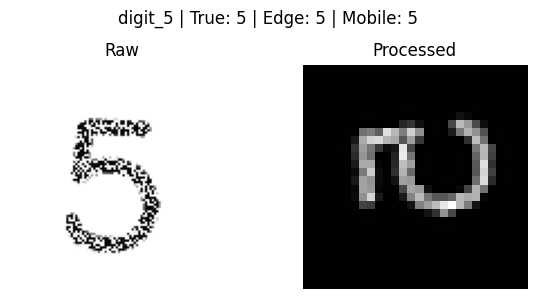

digit_5:
  EdgeCNN : 5 (0.81) 2.2ms
    Top-3 : [('5', 0.806059718132019), ('S', 0.15818452835083008), ('s', 0.024127593263983727)]
  Mobile  : 5 (0.81) 1.3ms
    Top-3 : [('5', 0.806059718132019), ('S', 0.15818452835083008), ('s', 0.024127593263983727)]
  ✓ Correct Edge: True, ✓ Correct Mobile: True, ✓ Match: True
------------------------------------------------------------


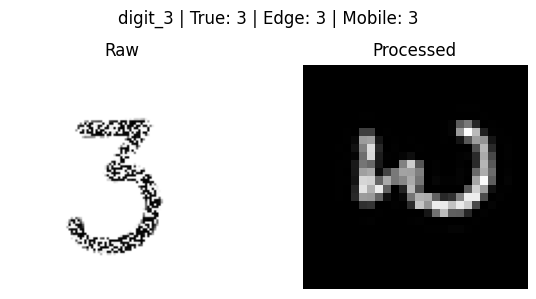

digit_3:
  EdgeCNN : 3 (0.86) 2.1ms
    Top-3 : [('3', 0.8580892086029053), ('S', 0.055036723613739014), ('5', 0.04927513003349304)]
  Mobile  : 3 (0.86) 1.4ms
    Top-3 : [('3', 0.8580892086029053), ('S', 0.055036723613739014), ('5', 0.04927513003349304)]
  ✓ Correct Edge: True, ✓ Correct Mobile: True, ✓ Match: True
------------------------------------------------------------


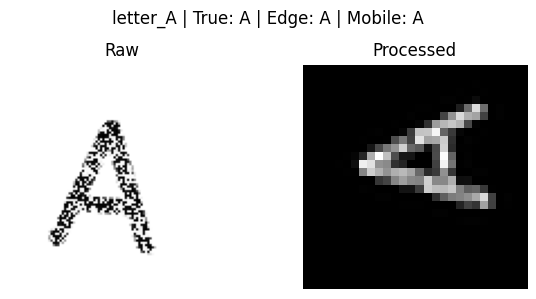

letter_A:
  EdgeCNN : A (0.46) 2.0ms
    Top-3 : [('A', 0.4641891419887543), ('a', 0.07927949726581573), ('h', 0.06852634996175766)]
  Mobile  : A (0.46) 1.4ms
    Top-3 : [('A', 0.4641891419887543), ('a', 0.07927949726581573), ('h', 0.06852634996175766)]
  ✓ Correct Edge: True, ✓ Correct Mobile: True, ✓ Match: True
------------------------------------------------------------


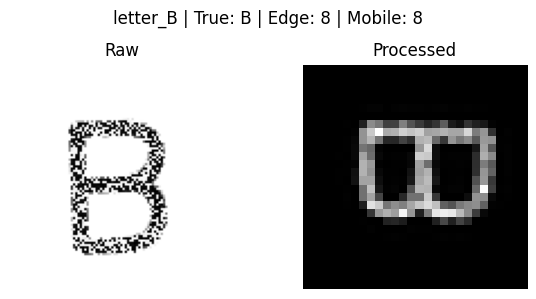

letter_B:
  EdgeCNN : 8 (0.51) 1.9ms
    Top-3 : [('8', 0.5096811056137085), ('B', 0.08493012189865112), ('0', 0.058655064553022385)]
  Mobile  : 8 (0.51) 1.4ms
    Top-3 : [('8', 0.5096811056137085), ('B', 0.08493012189865112), ('0', 0.058655064553022385)]
  ✓ Correct Edge: False, ✓ Correct Mobile: False, ✓ Match: True
------------------------------------------------------------


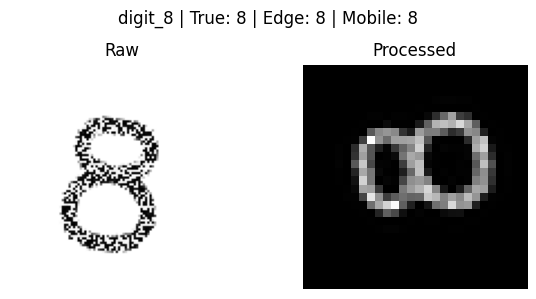

digit_8:
  EdgeCNN : 8 (0.59) 1.9ms
    Top-3 : [('8', 0.5857373476028442), ('3', 0.07640955597162247), ('g', 0.06059372425079346)]
  Mobile  : 8 (0.59) 1.3ms
    Top-3 : [('8', 0.5857373476028442), ('3', 0.07640955597162247), ('g', 0.06059372425079346)]
  ✓ Correct Edge: True, ✓ Correct Mobile: True, ✓ Match: True
------------------------------------------------------------
🔚 Overall:
   EdgeCNN Accuracy      : 80.0%
   Mobile Model Accuracy : 80.0%
   Prediction Consistency: 100.0%

❌ Misclassified Samples:


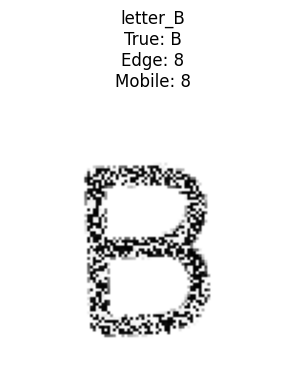

In [17]:
#@title ## 🧪 Actual Image Test

import numpy as np
import cv2
import os
import time
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Generate augmented test images
def create_augmented_test_images():
    print("🎨 Generating augmented test images...")
    test_images = {}

    def add_noise(img):
        noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
        return np.clip(cv2.add(img, noise), 0, 255)

    def apply_random_rotation(img, angle_range=10):
        angle = np.random.uniform(-angle_range, angle_range)
        center = (img.shape[1]//2, img.shape[0]//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderValue=255)

    base_images = {
        "digit_5": "5",
        "digit_3": "3",
        "letter_A": "A",
        "letter_B": "B",
        "digit_8": "8"
    }

    for name, char in base_images.items():
        img = np.ones((100, 100), dtype=np.uint8) * 255
        cv2.putText(img, char, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 2.5, 0, 5)
        img = apply_random_rotation(img)
        img = add_noise(img)
        filename = f"test_{name}.png"
        cv2.imwrite(filename, img)
        test_images[name] = filename
        print(f"   - {name} saved as {filename}")

    return test_images

# 2. Preprocess image to match EMNIST format
def preprocess_emnist_image(image_path):
    image = Image.open(image_path).convert("L")
    image = np.array(image)
    image = 255 - image if np.mean(image) > 127 else image
    coords = cv2.findNonZero(255 - image)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        image = image[y:y+h, x:x+w]
    h, w = image.shape
    max_dim = max(h, w)
    pad_h = (max_dim - h) // 2
    pad_w = (max_dim - w) // 2
    image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    image = np.rot90(image, k=3)
    image = np.fliplr(image)
    image = Image.fromarray(image).resize((28, 28), resample=Image.LANCZOS)
    return np.array(image, dtype=np.uint8)

# 3. Predict with both models + measure latency
def predict_with_models(processed_img, edge_model, traced_model, device):
    emnist_classes = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    input_tensor = transform(processed_img).unsqueeze(0).to(device)

    results = {}

    # EdgeCNN
    edge_model.eval()
    with torch.no_grad():
        start = time.perf_counter()
        output = edge_model(input_tensor)
        latency = (time.perf_counter() - start) * 1000
        probs = torch.softmax(output, dim=1)
        pred_idx = output.argmax(1).item()
        results['EdgeCNN'] = {
            'prediction': emnist_classes[pred_idx],
            'confidence': probs.max().item(),
            'latency_ms': latency,
            'top3': [(emnist_classes[i.item()], probs[0, i].item()) for i in probs[0].topk(3).indices]
        }

    # Mobile model
    traced_model.eval()
    with torch.no_grad():
        start = time.perf_counter()
        output = traced_model(input_tensor)
        latency = (time.perf_counter() - start) * 1000
        probs = torch.softmax(output, dim=1)
        pred_idx = output.argmax(1).item()
        results['Mobile'] = {
            'prediction': emnist_classes[pred_idx],
            'confidence': probs.max().item(),
            'latency_ms': latency,
            'top3': [(emnist_classes[i.item()], probs[0, i].item()) for i in probs[0].topk(3).indices]
        }

    return results

# 4. Evaluation + visualization per sample
def evaluate_prediction_results(results_dict, expected_labels):
    correct_edge, correct_mobile, consistency, total = 0, 0, 0, len(results_dict)
    errors = []

    print("\n📊 Evaluation Summary:")
    for key, result in results_dict.items():
        expected = expected_labels[key]
        edge_pred = result['EdgeCNN']['prediction']
        mobile_pred = result['Mobile']['prediction']
        edge_correct = edge_pred == expected
        mobile_correct = mobile_pred == expected
        match = edge_pred == mobile_pred

        correct_edge += edge_correct
        correct_mobile += mobile_correct
        consistency += match

        if not edge_correct or not mobile_correct:
            errors.append((key, expected, edge_pred, mobile_pred))

        # Visualize each sample
        raw_img = Image.open(f"test_{key}.png")
        proc_img = preprocess_emnist_image(f"test_{key}.png")
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(raw_img, cmap='gray')
        axs[0].set_title("Raw")
        axs[0].axis("off")
        axs[1].imshow(proc_img, cmap='gray')
        axs[1].set_title("Processed")
        axs[1].axis("off")
        plt.suptitle(f"{key} | True: {expected} | Edge: {edge_pred} | Mobile: {mobile_pred}")
        plt.tight_layout()
        plt.show()

        print(f"{key}:")
        print(f"  EdgeCNN : {edge_pred} ({result['EdgeCNN']['confidence']:.2f}) {result['EdgeCNN']['latency_ms']:.1f}ms")
        print(f"    Top-3 : {result['EdgeCNN']['top3']}")
        print(f"  Mobile  : {mobile_pred} ({result['Mobile']['confidence']:.2f}) {result['Mobile']['latency_ms']:.1f}ms")
        print(f"    Top-3 : {result['Mobile']['top3']}")
        print(f"  ✓ Correct Edge: {edge_correct}, ✓ Correct Mobile: {mobile_correct}, ✓ Match: {match}")
        print("-" * 60)

    print("🔚 Overall:")
    print(f"   EdgeCNN Accuracy      : {correct_edge / total:.1%}")
    print(f"   Mobile Model Accuracy : {correct_mobile / total:.1%}")
    print(f"   Prediction Consistency: {consistency / total:.1%}")

    if errors:
        print("\n❌ Misclassified Samples:")
        fig, axes = plt.subplots(1, len(errors), figsize=(4 * len(errors), 4))
        if len(errors) == 1: axes = [axes]
        for i, (name, expected, edge_p, mobile_p) in enumerate(errors):
            img = Image.open(f"test_{name}.png")
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"{name}\nTrue: {expected}\nEdge: {edge_p}\nMobile: {mobile_p}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

# 5. Full pipeline runner
def run_real_image_test(edge_model, traced_model, device):
    test_images = create_augmented_test_images()
    expected_labels = {
        "digit_5": "5",
        "digit_3": "3",
        "letter_A": "A",
        "letter_B": "B",
        "digit_8": "8"
    }
    all_results = {}
    for name, path in test_images.items():
        processed = preprocess_emnist_image(path)
        result = predict_with_models(processed, edge_model, traced_model, device)
        all_results[name] = result

    evaluate_prediction_results(all_results, expected_labels)

run_real_image_test(edge_model, traced_model, device)